In [84]:
import pydpmd as dp
from pydpmd.plot import draw_particles_frame
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
from matplotlib.colors import LogNorm
from pydpmd.utils import split_systems, join_systems

def fit_log(_x, _y, n=1, min_cut_pct=None, max_cut_pct=None):
    mask = np.ones(_x.shape[0], dtype=bool)
    if min_cut_pct:
        mask &= (_x >= min_cut_pct * _x.max())
    if max_cut_pct:
        mask &= (_x <= max_cut_pct * _x.max())
    x = np.log10(_x[mask])
    y = np.log10(_y[mask])
    # fit the exponent
    n_measured, log_d = np.polyfit(x, y, 1)
    if n is None:
        d = 10 ** log_d
        y_pred = n_measured * x + log_d
    else:
        # fit the prefactor using the assumed exponent
        def obj(b, x, y):
            return np.sum((y - (n * x + b)) ** 2)
        log_d = minimize(obj, log_d, args=(x, y)).x[0]
        d = 10 ** log_d
        y_pred = n * x + log_d
    r2 = 1 - np.sum((y - y_pred) ** 2) / np.sum((y - np.mean(y)) ** 2)
    return d, n_measured, r2

def get_relaxation_time(f, t, max_t=None):
    if max_t is None:
        max_t = max(t)
    mask = t <= max_t
    tau = np.interp(1 / np.e, f[mask][::-1], t[mask][::-1])
    if not np.min(f) < 1 / np.e:
        return np.nan
    return tau

def fit_power_left(x, y, xc_min=None, xc_max=None, n_grid=2001, min_pts=5):
    x = np.asarray(x).ravel()
    y = np.asarray(y).ravel()
    if x.size != y.size:
        raise ValueError("x and y must have same length.")
    # need positive y for log
    m = np.isfinite(x) & np.isfinite(y) & (y > 0)
    x, y = x[m], y[m]
    if x.size < min_pts:
        raise ValueError("Not enough positive-y points.")

    # build a simple xc grid
    xmin, xmax = x.min(), x.max()
    span = xmax - xmin if xmax > xmin else 1.0
    if xc_min is None: xc_min = xmax - 0.2 * span
    if xc_max is None: xc_max = xmax + 0.2 * span
    if not (np.isfinite(xc_min) and np.isfinite(xc_max) and xc_max > xc_min):
        raise ValueError("Bad xc bounds.")
    xc_grid = np.linspace(xc_min, xc_max, int(n_grid))

    best = {'SSE': np.inf, 'xc': None, 'n': None, 'A': None}
    for xc in xc_grid:
        sel = x < xc
        if sel.sum() < min_pts:
            continue
        u = np.log(xc - x[sel])        # ln(xc - x)
        v = np.log(y[sel])             # ln y
        # linear fit: v = alpha + n * u
        p = np.polyfit(u, v, 1)        # p[0]=n, p[1]=alpha
        vhat = p[0] * u + p[1]
        sse = np.sum((v - vhat) ** 2)
        if sse < best['SSE']:
            best['SSE'] = float(sse)
            best['xc']  = float(xc)
            best['n']   = float(p[0])
            best['A']   = float(np.exp(p[1]))
    if best['xc'] is None:
        raise RuntimeError("No admissible xc produced a fit. Widen xc bounds.")
    return best


def fit_D_density_vft(phi, D, phi0_grid=None, delta_grid=None, min_pts=6):
    """Fit ln D = a - b * (phi0 - phi)^(-delta), phi < phi0."""
    phi = np.asarray(phi).ravel(); D = np.asarray(D).ravel()
    m = np.isfinite(phi) & np.isfinite(D) & (D > 0)
    phi, D = phi[m], D[m]
    if phi.size < min_pts: raise ValueError("Not enough positive-D points.")
    span = np.ptp(phi) if np.ptp(phi) > 0 else 1.0
    if phi0_grid is None:
        lo = phi.max() + 0.02*span; hi = phi.max() + 0.3*span
        phi0_grid = np.linspace(lo, hi, 161)
    if delta_grid is None:
        delta_grid = np.linspace(1.0, 2.5, 141)
    best = {'SSE': np.inf}
    for phi0 in phi0_grid:
        sel = phi < phi0
        if sel.sum() < min_pts: continue
        s = phi0 - phi[sel]
        for delta in delta_grid:
            t = 1.0 / np.power(s, delta)         # predictor
            v = np.log(D[sel])                   # response
            p = np.polyfit(t, v, 1)              # v = a + p[0]*t; here p[0] ~ -b
            vhat = p[0]*t + p[1]
            sse = np.sum((v - vhat)**2)
            if sse < best['SSE']:
                best = {'phi0': float(phi0), 'delta': float(delta),
                        'a': float(p[1]), 'b': float(-p[0]), 'SSE': float(sse)}
    if np.isinf(best['SSE']): raise RuntimeError("Widen grids.")
    best['D0'] = float(np.exp(best['a']))
    # Model: D(phi) ≈ D0 * exp(- b / (phi0 - phi)^delta)
    return best

def get_peak_location(r, g, window_pct=0.99):
    mask = g >= np.max(g) * window_pct
    return np.mean(r[mask])

def fit_tau_density_vft(phi, tau, phi0_grid=None, delta_grid=None, min_pts=6):
    phi = np.asarray(phi).ravel()
    tau = np.asarray(tau).ravel()
    m = np.isfinite(phi) & np.isfinite(tau) & (tau > 0)
    phi, tau = phi[m], tau[m]
    if phi.size < min_pts:
        raise ValueError("Not enough positive-τ points.")

    # default grids: search a bit above max φ, and δ≈[0.8, 2.5]
    span = np.ptp(phi) if np.ptp(phi) > 0 else 1.0
    if phi0_grid is None:
        hi = phi.max() + 0.3*span
        lo = phi.max() + 0.02*span
        phi0_grid = np.linspace(lo, hi, 181)
    if delta_grid is None:
        delta_grid = np.linspace(1.0, 2.0, 171)

    best = {'SSE': np.inf}
    for phi0 in phi0_grid:
        sel = phi < phi0
        if sel.sum() < min_pts:
            continue
        s = (phi0 - phi[sel])
        for delta in delta_grid:
            t = 1.0 / np.power(s, delta)               # predictor
            v = np.log(tau[sel])                        # response
            X = np.vstack([np.ones_like(t), t]).T       # v = a + b t
            coef, *_ = np.linalg.lstsq(X, v, rcond=None)
            resid = v - X @ coef
            sse = float((resid**2).sum())
            if sse < best['SSE']:
                best = {'phi0': float(phi0), 'delta': float(delta),
                        'a': float(coef[0]), 'b': float(coef[1]), 'SSE': sse}
    if np.isinf(best['SSE']):
        raise RuntimeError("No valid (phi0, delta) found. Widen grids.")
    best['tau0'] = float(np.exp(best['a']))
    best['A'] = best['b']          # so τ ≈ τ0 * exp(A / (φ0-φ)^δ)
    return best


def my_fit_left(x, y, n_x_grids=100, xc_min=None, xc_max=None, tail_length=None, min_points=10):
    if xc_min is None:
        xc_min = x.max() * 0.9
    if xc_max is None:
        xc_max = x.max() * 1.1
    if tail_length is None:
        tail_length = x.size

    x_grid = np.linspace(xc_min, xc_max, n_x_grids)

    errors = []
    for xc in x_grid:
        delta = np.log10(xc - x)
        f = np.log10(y)
        mask = ~(np.isnan(f) | np.isnan(delta))
        if np.sum(mask) < min_points:
            sse = np.inf
        else:
            m, b = np.polyfit(delta[mask], f[mask], 1)
            sse = np.sum((m * delta[mask][:tail_length] + b - f[mask][:tail_length]) ** 2)
        errors.append(sse)

    xc = x_grid[np.argmin(errors)]
    delta = np.log10(xc - x)
    f = np.log10(y)
    mask = ~(np.isnan(f) | np.isnan(delta))
    m, b = np.polyfit(delta[mask], f[mask], 1)

    return {
        'xc': xc,
        'sse': min(errors),
        'A': 10 ** b,
        'n': m
    }

In [65]:
root = '/Users/marshallmccraw/Projects/yale/data/s-25/10-02-25/grace-data/'
T = 1e-6

old_dir = os.path.join(root, 'rb-compression-diffusion-lower-temp')
old_dt = 5e-2

new_trans_dir = os.path.join(root, 'rb-compression-diffusion-lower-temp-continuing-translations')
new_trans_dt = 1e-1

one_offs_new_trans_dir = os.path.join(root, 'rb-compression-diffusion-lower-temp-continuing-translations-one-offs')
one_off_trans_dt_map = {((4, 0.5), (4, 1.00), (7, 1.00), (11, 1.00), (21, 1.00), (31, 1.00), (21, 0.01), (31, 0.01)): old_dt}
one_off_trans_dt_otherwise = new_trans_dt

new_rot_dir = os.path.join(root, 'rb-compression-diffusion-lower-temp-continuing-rotations')
new_rot_dt = 5e-2

dilute_limit_dir = os.path.join(root, 'rb-compression-diffusion-lower-temp-dilute-limit')
dilute_limit_dt = 5e-2

# Merging the Data

In [66]:
old_data = []
for root, dirs, files in os.walk(old_dir):
    for dirname in dirs:
        if 'dynamics_' in dirname:
            d = dp.data.load(os.path.join(root, dirname), location=['final', 'init'])
            d.calculate_mu_eff()
            d.add_array(np.ones_like(d.system_size) * old_dt, 'dt')
            if 'msd' not in d.final.arrays.keys():
                print(f'{os.path.join(os.path.basename(root), dirname)} does not have msd')
                continue
            old_data.append(d)

new_trans_data = []
for root, dirs, files in os.walk(new_trans_dir):
    for dirname in dirs:
        if 'dynamics_' in dirname:
            d = dp.data.load(os.path.join(root, dirname), location=['final', 'init'])
            d.calculate_mu_eff()
            d.add_array(np.ones_like(d.system_size) * new_trans_dt, 'dt')
            if 'msd' not in d.final.arrays.keys():
                print(f'{os.path.join(os.path.basename(root), dirname)} does not have msd')
                continue
            new_trans_data.append(d)

new_trans_data_one_offs = []
for root, dirs, files in os.walk(one_offs_new_trans_dir):
    for dirname in dirs:
        if 'dynamics_' in dirname:
            d = dp.data.load(os.path.join(root, dirname), location=['final', 'init'])
            d.calculate_mu_eff()
            mu_eff_name = float(root.split('mu_eff-')[-1].split('/')[0])
            dts = []
            for _nv in d.n_vertices_per_particle[d.system_offset[:-1]]:
                if (_nv, mu_eff_name) in list(one_off_trans_dt_map.keys())[0]:
                    dts.append(list(one_off_trans_dt_map.values())[0])
                else:
                    dts.append(one_off_trans_dt_otherwise)
            d.add_array(np.array(dts), 'dt')
            if 'msd' not in d.final.arrays.keys():
                print(f'{os.path.join(os.path.basename(root), dirname)} does not have msd')
                continue
            new_trans_data_one_offs.append(d)

new_rot_data = []
for root, dirs, files in os.walk(new_rot_dir):
    for dirname in dirs:
        if 'dynamics_' in dirname:
            d = dp.data.load(os.path.join(root, dirname), location=['final', 'init'])
            d.calculate_mu_eff()
            d.add_array(np.ones_like(d.system_size) * new_rot_dt, 'dt')
            if 'msd' not in d.final.arrays.keys():
                print(f'{os.path.join(os.path.basename(root), dirname)} does not have msd')
                continue
            new_rot_data.append(d)

dilute_data = []
for root, dirs, files in os.walk(dilute_limit_dir):
    for dirname in dirs:
        if 'dynamics_' in dirname:
            d = dp.data.load(os.path.join(root, dirname), location=['final', 'init'])
            d.calculate_mu_eff()
            d.add_array(np.ones_like(d.system_size) * dilute_limit_dt, 'dt')
            if 'msd' not in d.final.arrays.keys():
                print(f'{os.path.join(os.path.basename(root), dirname)} does not have msd')
                continue
            dilute_data.append(d)

mu_eff-0.10/dynamics_8 does not have msd
mu_eff-0.05/dynamics_8 does not have msd
mu_eff-0.50/dynamics_6 does not have msd
mu_eff-1.00/dynamics_0 does not have msd
mu_eff-0.01/dynamics_0 does not have msd
nv-21/dynamics_6 does not have msd
nv-31/dynamics_4 does not have msd
nv-21/dynamics_3 does not have msd
nv-11/dynamics_8 does not have msd
nv-31/dynamics_2 does not have msd


In [67]:
nv = np.concatenate([d.n_vertices_per_particle[d.system_offset[:-1]] for d in old_data])
mu = np.concatenate([d.mu_eff[d.system_offset[:-1]] for d in old_data])
nv_mu_vals = np.unique(np.column_stack((nv, mu)), axis=0)

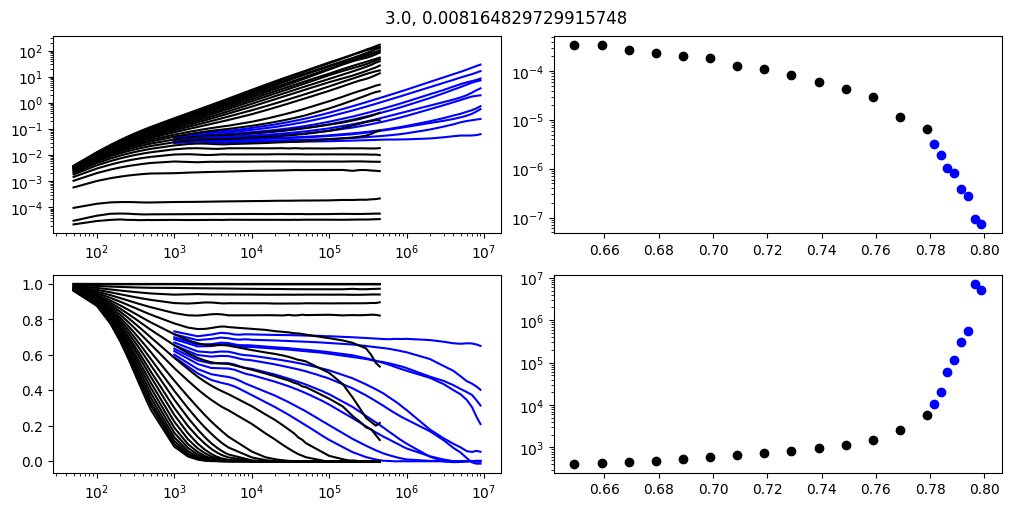

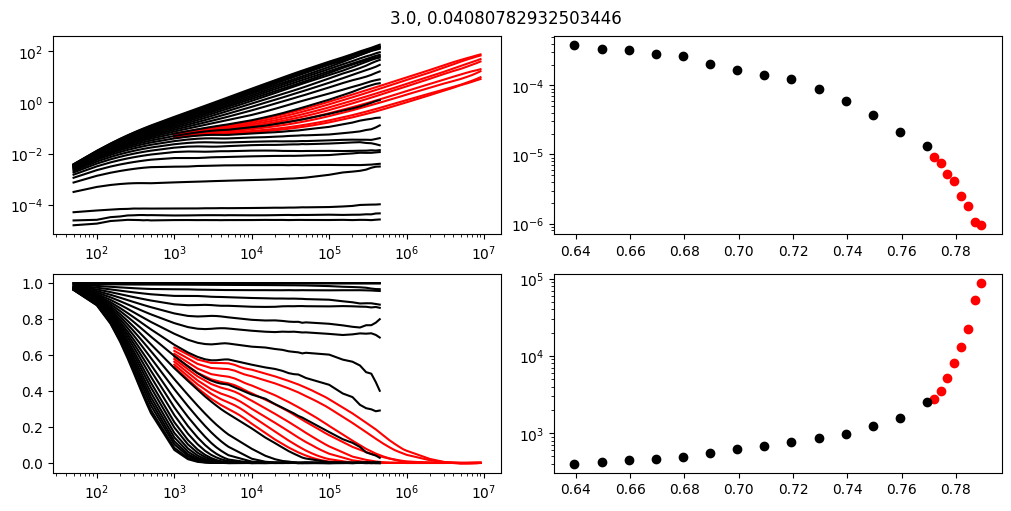

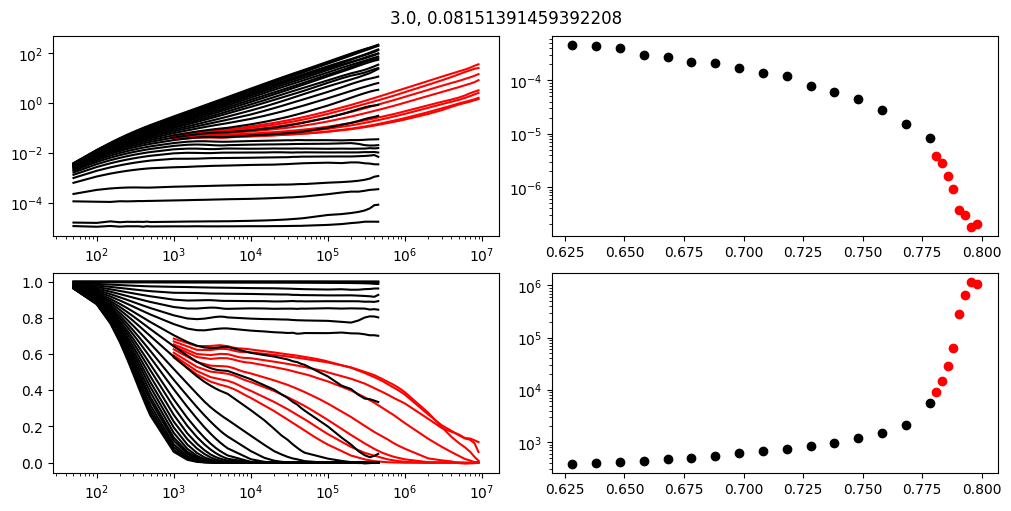

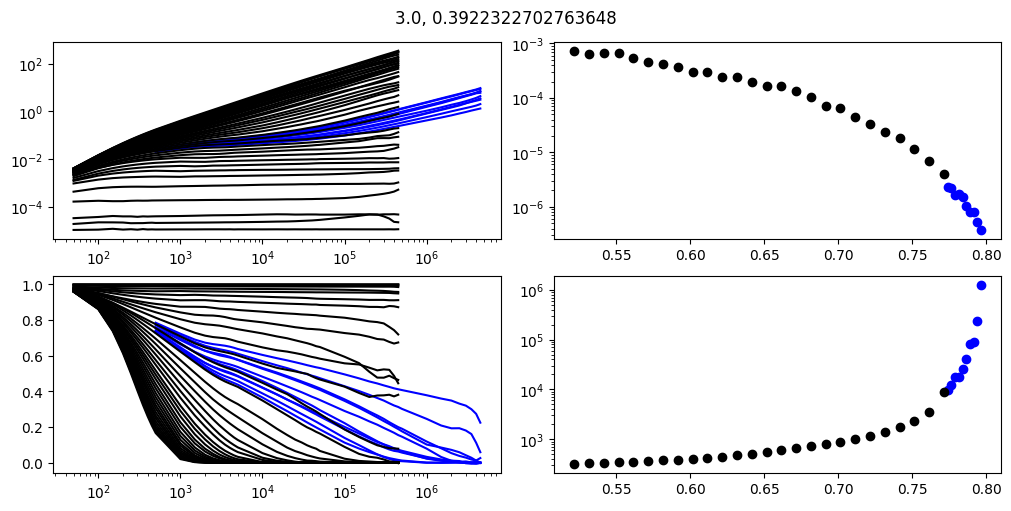

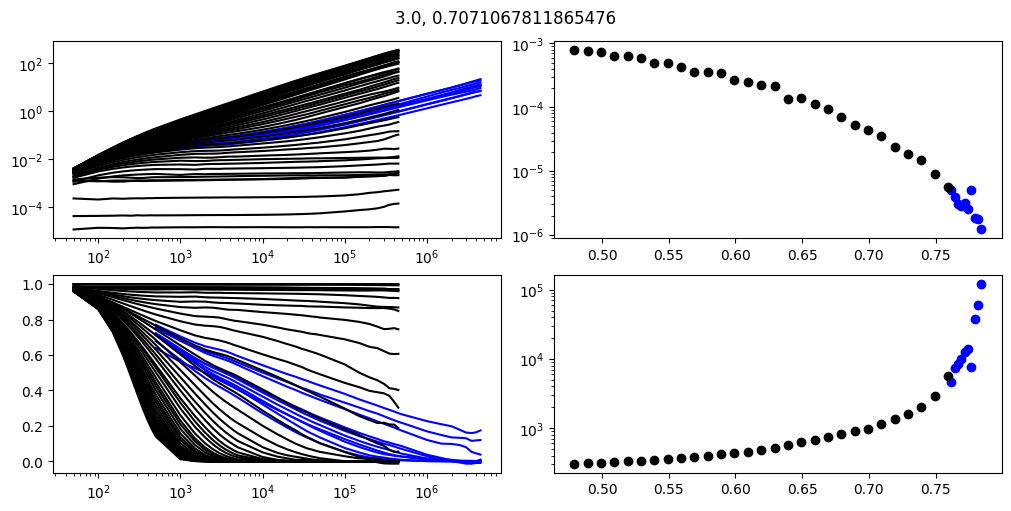

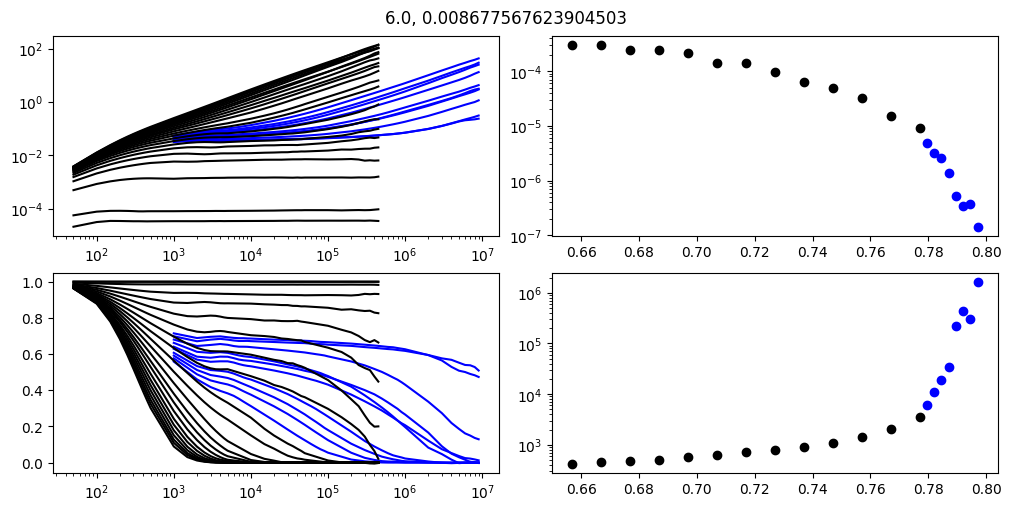

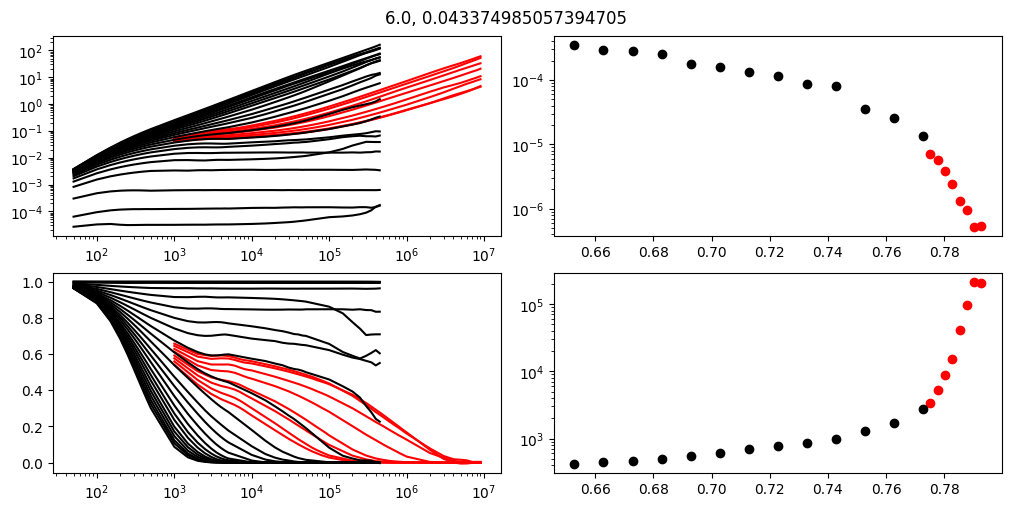

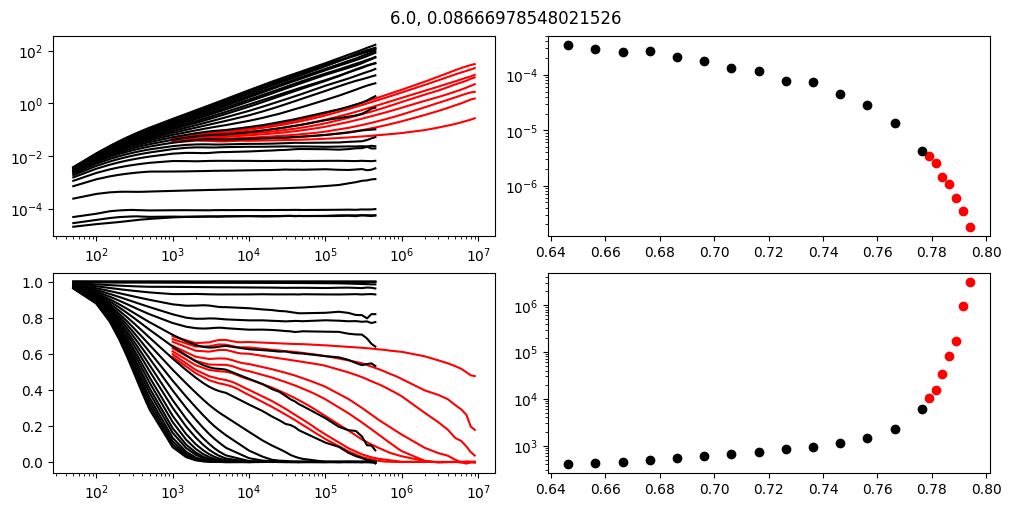

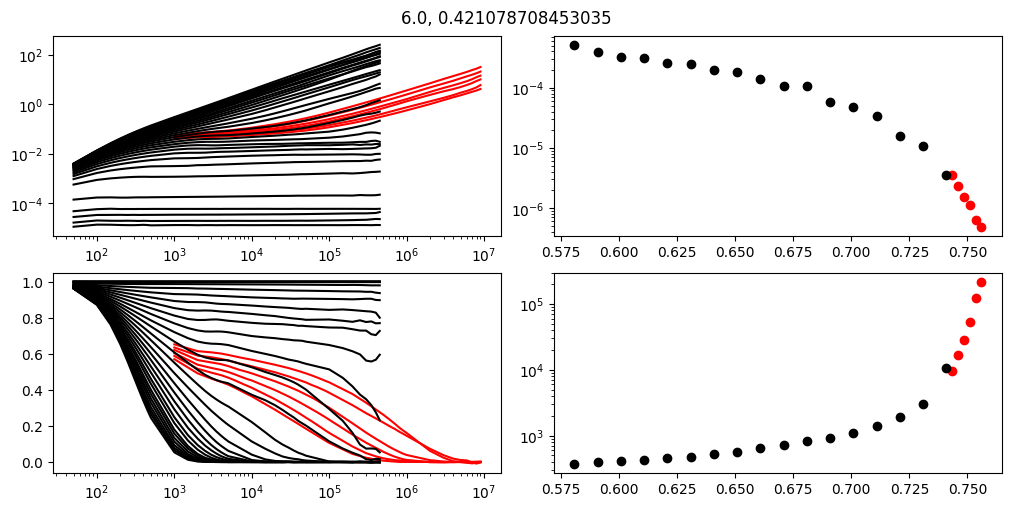

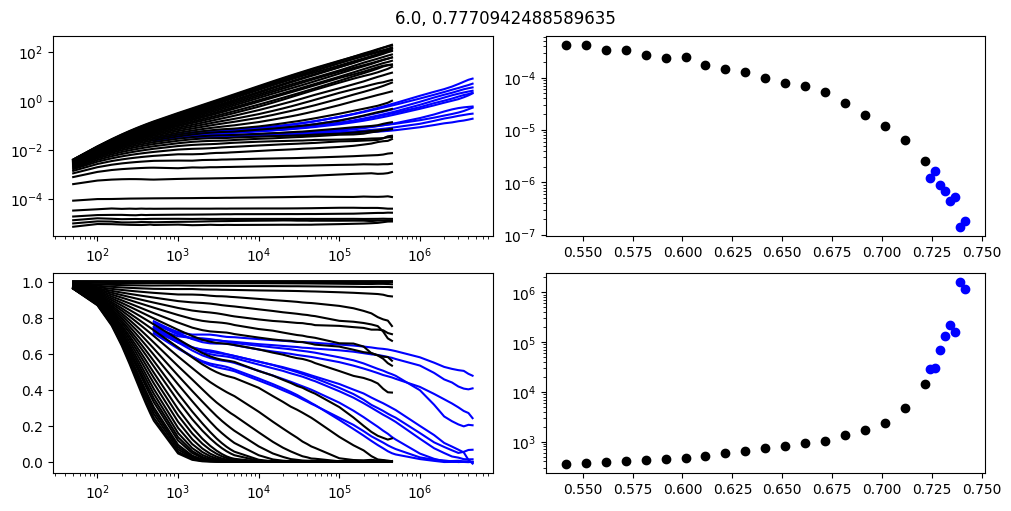

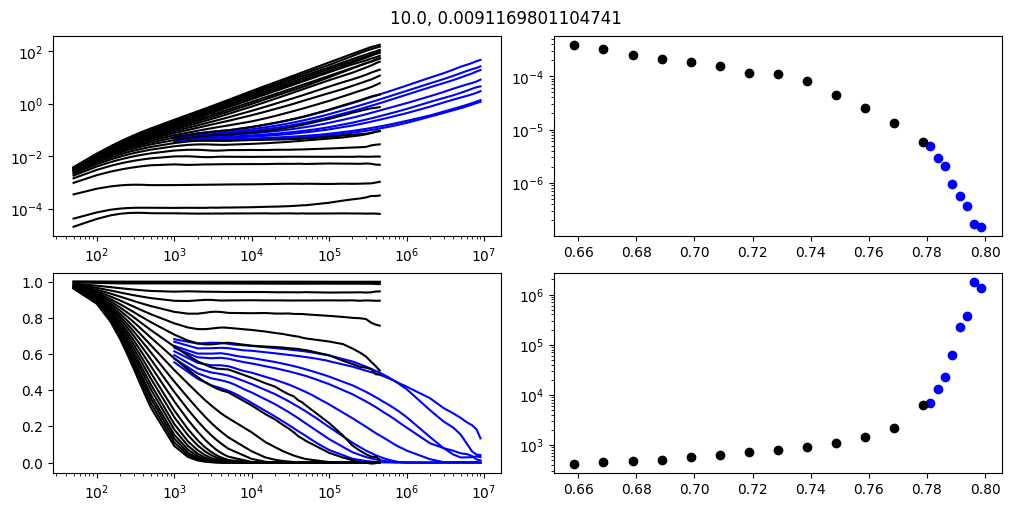

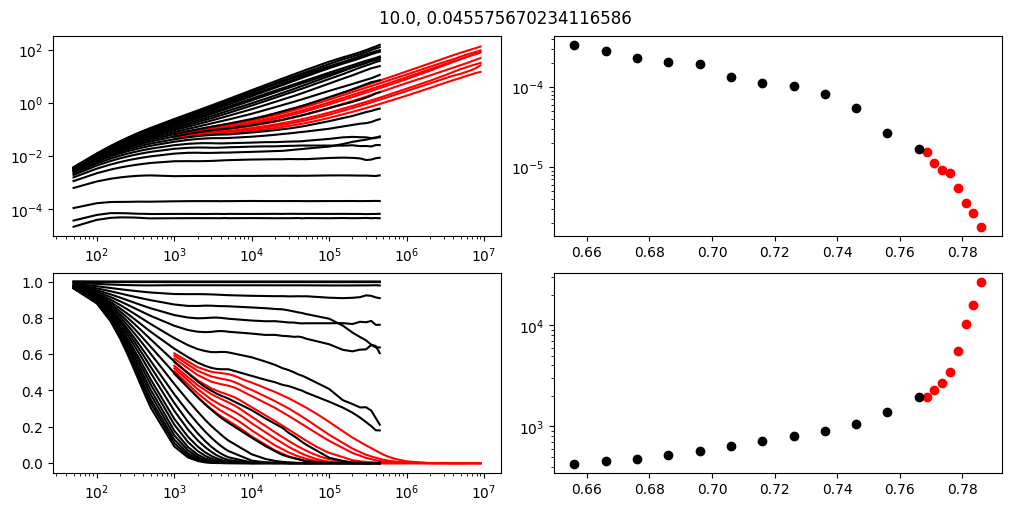

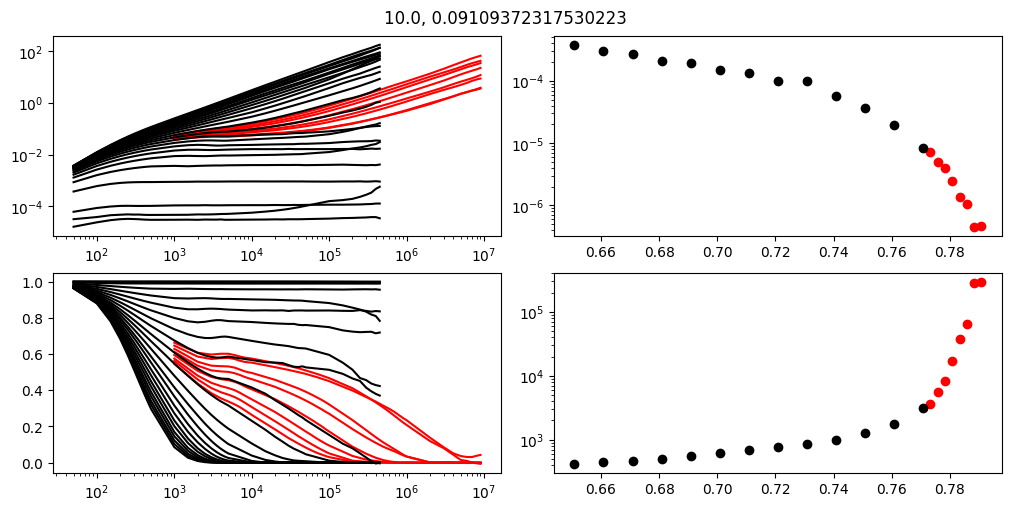

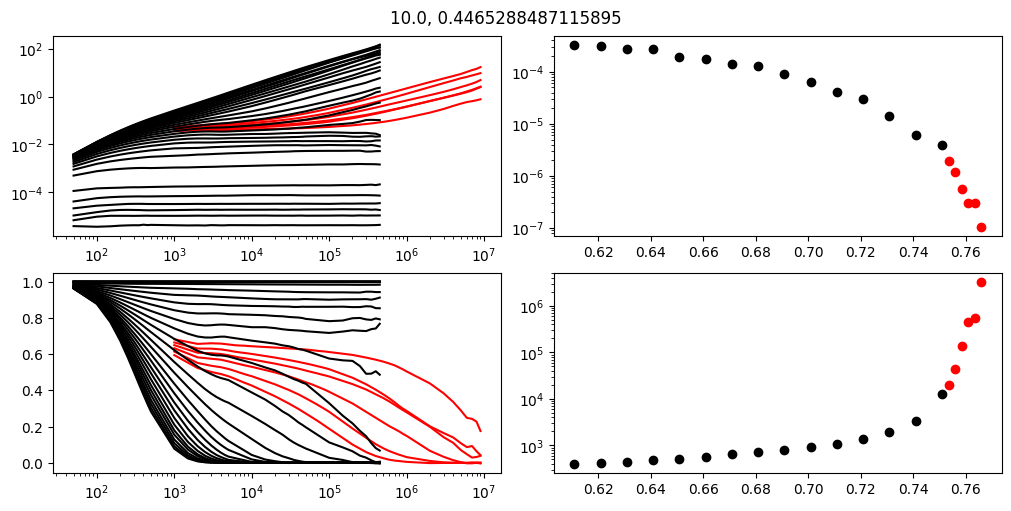

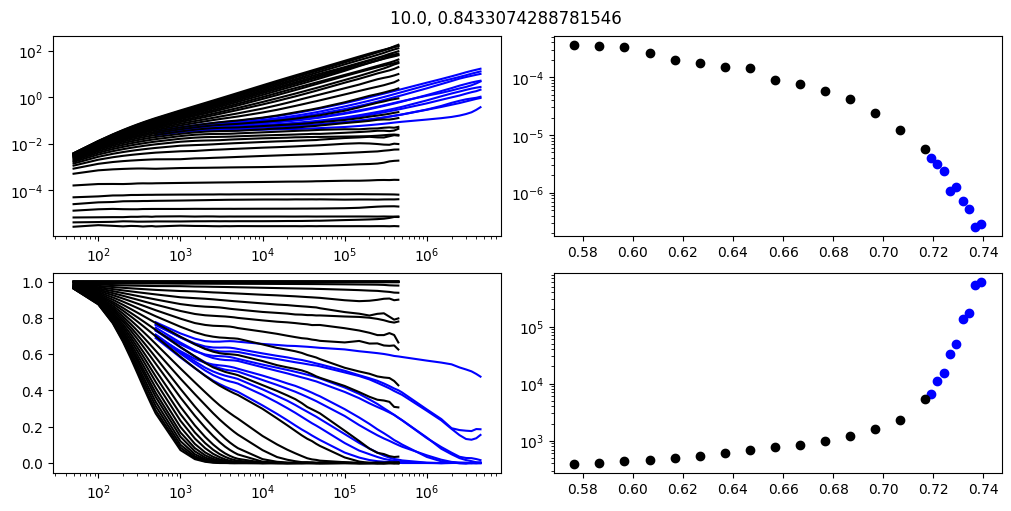

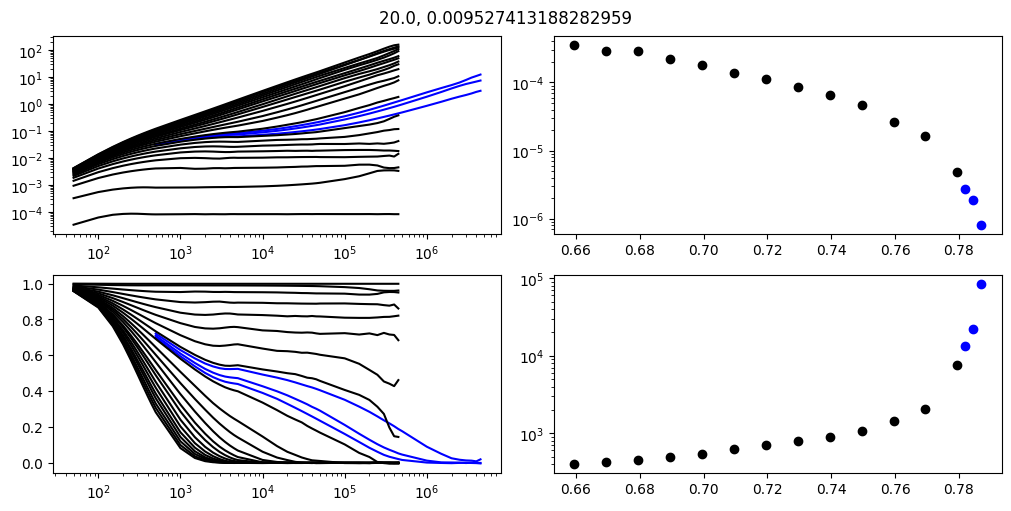

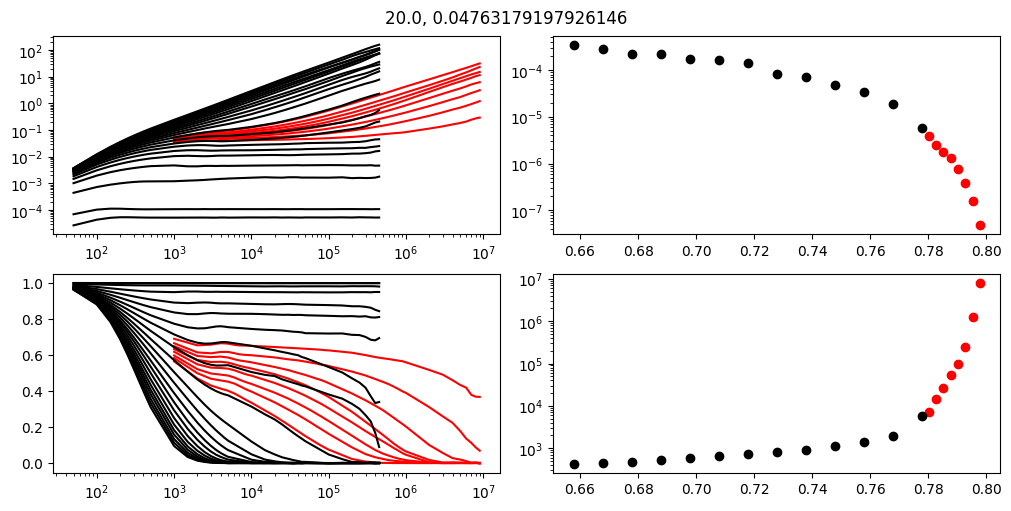

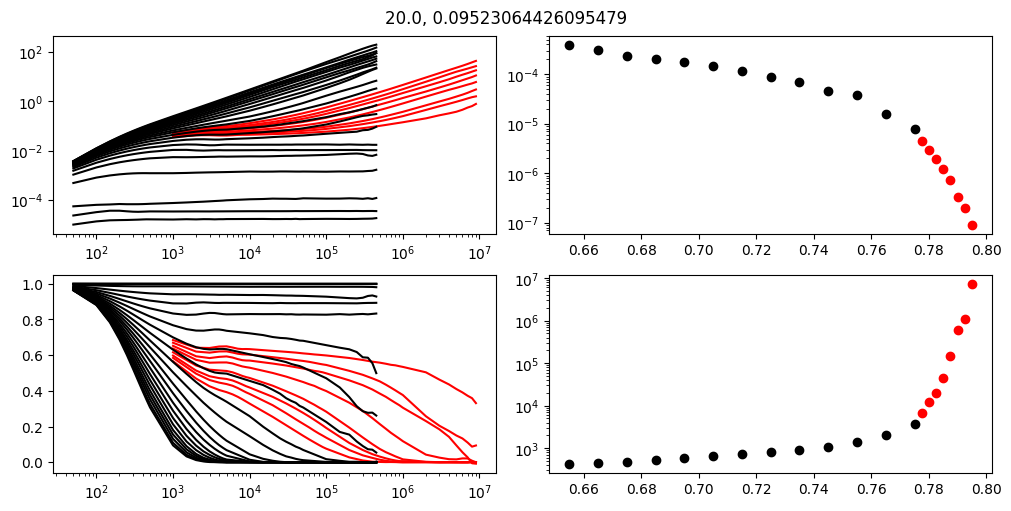

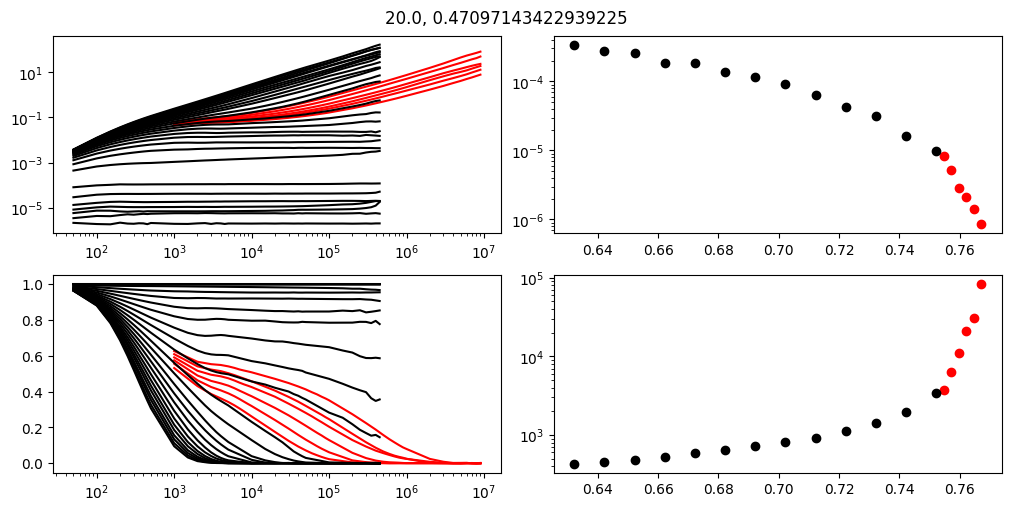

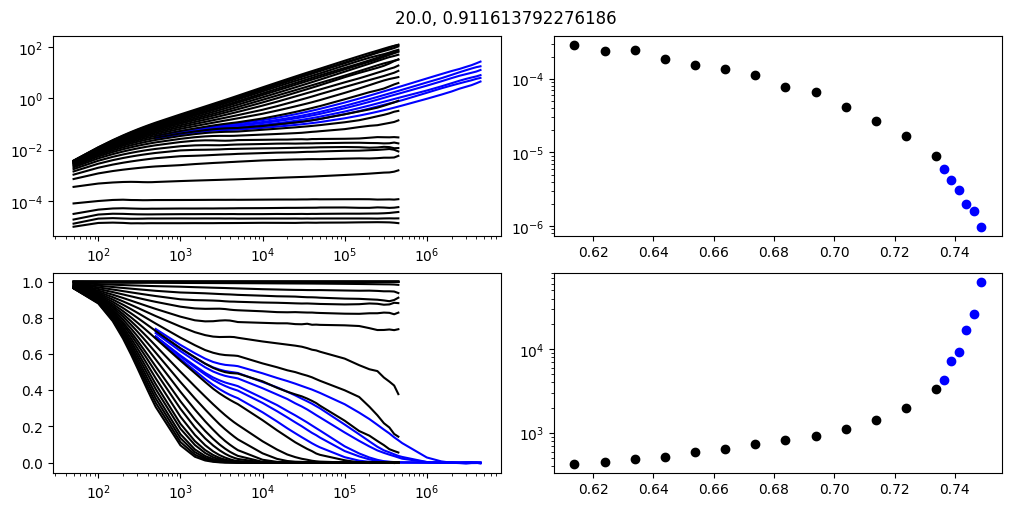

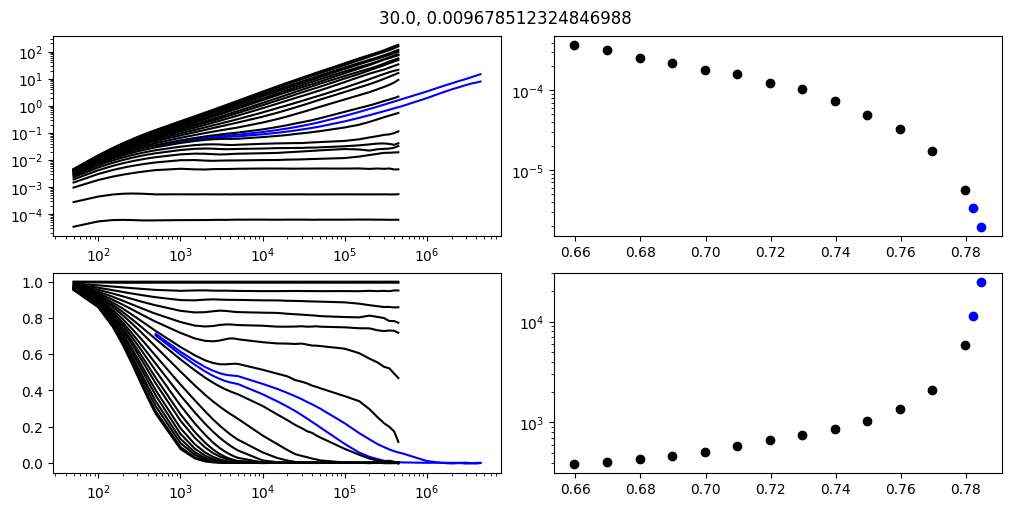

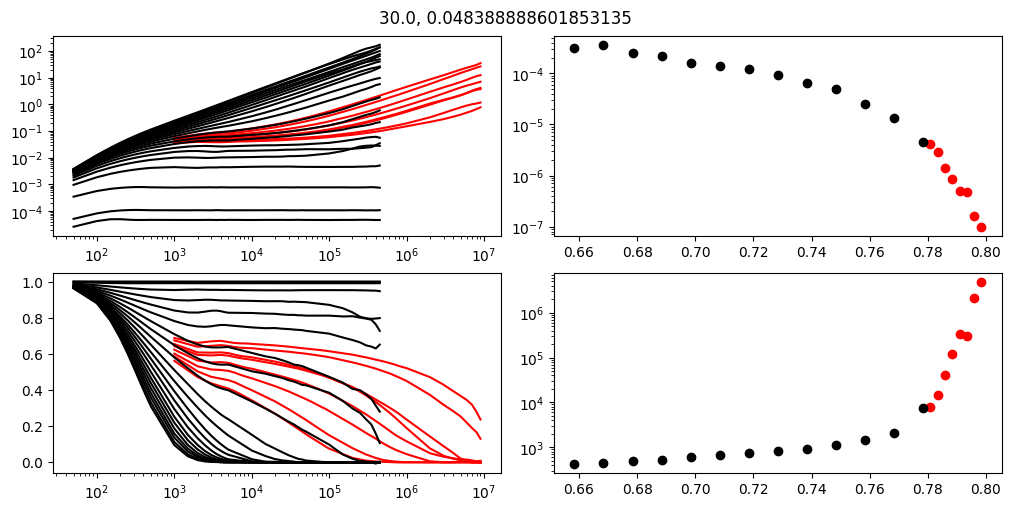

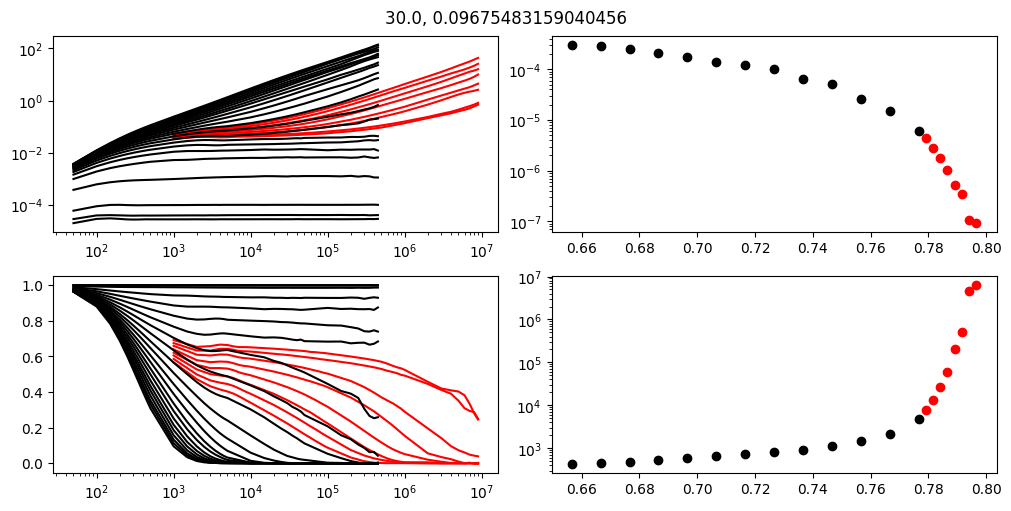

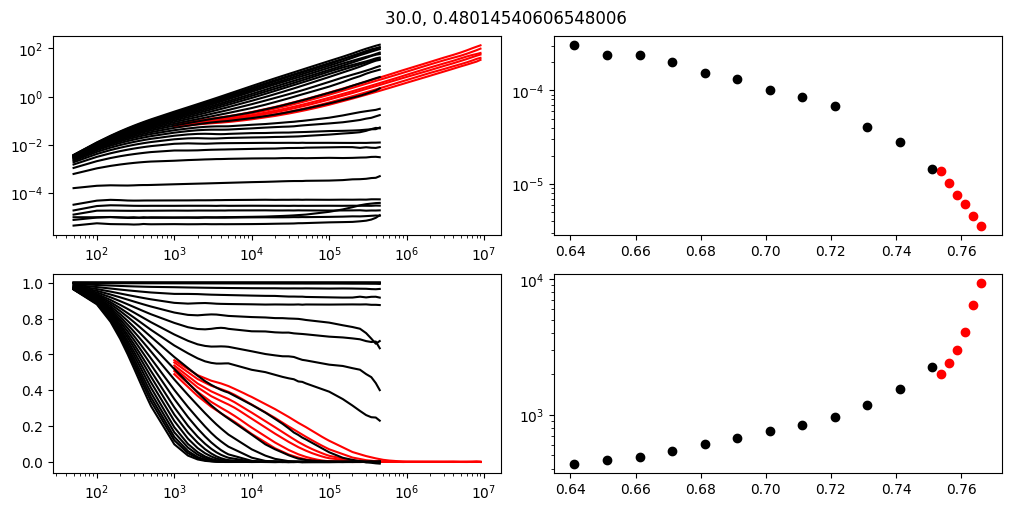

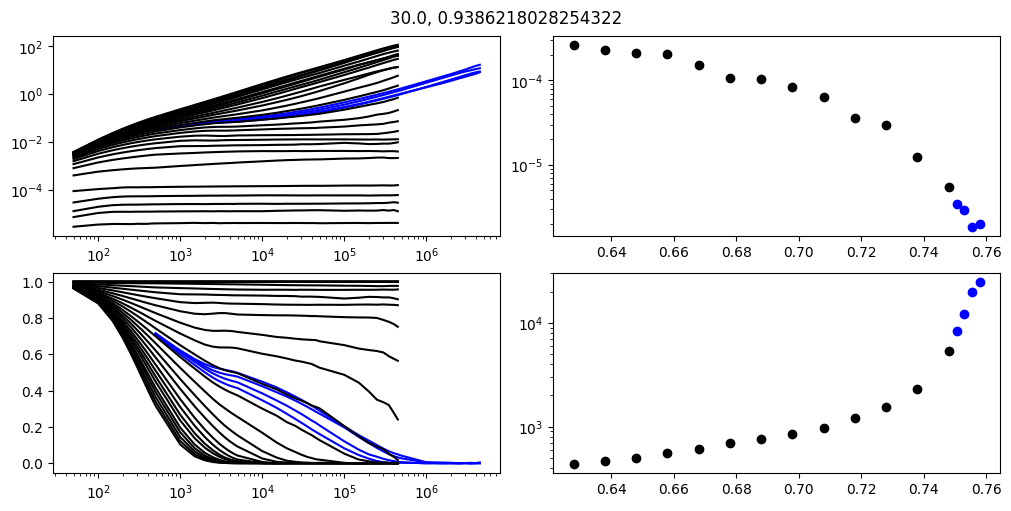

In [68]:
datasets = {}
for nv_mu in nv_mu_vals:
    dataset = {}
    max_phi = np.inf
    fig, ax = plt.subplots(2, 2, figsize=(10, 5), constrained_layout=True)
    for data, color in zip([new_trans_data, new_trans_data_one_offs, old_data], ['r', 'b', 'k']):
        for d in data:
            split_data = split_systems(d)
            for i, (_nv, _mu) in enumerate(zip(d.n_vertices_per_particle[d.system_offset[:-1]], d.mu_eff[d.system_offset[:-1]])):
                if _nv != nv_mu[0] or _mu != nv_mu[1]:
                    continue
                if _nv == 4 and np.isclose(_mu, 0.39223227, atol=1e-5) and color == 'r':
                    continue
                
                phi = d.packing_fraction[i]

                t = d.final.t * d.dt[i]
                m = d.final.msd[:, i, 0]
                D, n, R2 = fit_log(t, m, n=1, min_cut_pct=0.1, max_cut_pct=0.9)

                am = d.final.msd[:, i, 1]
                D_R, n_R, R2_R = fit_log(t, am, n=1, min_cut_pct=0.1, max_cut_pct=0.9)

                isf_small = d.final.isf[:, 0, i]
                tau_small = get_relaxation_time(isf_small, t, max_t=0.9 * max(t))

                isf_large = d.final.isf[:, 1, i]
                tau_large = get_relaxation_time(isf_large, t, max_t=0.9 * max(t))

                aisf_small = d.final.angular_isf[:, 0, i]
                tau_R_small = get_relaxation_time(aisf_small, t, max_t=0.9 * max(t))
                
                aisf_large = d.final.angular_isf[:, 1, i]
                tau_R_large = get_relaxation_time(aisf_large, t, max_t=0.9 * max(t))

                if np.isnan(tau_small):
                    D = np.nan
                if np.isnan(tau_R_small):
                    D_R = np.nan

                # if the color == 'k' (using old data) and the phi exceeds the maximum phi in the dataset (unrelaxed runs), set the scalars to nan
                if (color == 'b' or color == 'r') and len(list(dataset.keys())) > 0:
                    max_phi = min(list(dataset.keys()))
                if color == 'k' and phi > max_phi:
                    D = np.nan
                    D_R = np.nan
                    tau_small = np.nan
                    tau_R_small = np.nan
                    tau_large = np.nan
                    tau_R_large = np.nan
                dataset[phi] = {
                    'D': D,
                    'D_R': D_R,
                    'tau_small': tau_small,
                    'tau_R_small': tau_R_small,
                    'tau_large': tau_large,
                    'tau_R_large': tau_R_large,
                    'msd': m,
                    'am': am,
                    'isf_small': isf_small,
                    'isf_large': isf_large,
                    'aisf_small': aisf_small,
                    'aisf_large': aisf_large,
                    't': t,
                }

                ax[0, 0].plot(t, m, color=color)
                ax[0, 1].scatter(phi, D, color=color)
                ax[1, 0].plot(t, isf_small, color=color)
                ax[1, 1].scatter(phi, tau_small, color=color)
    for a in ax[:, -1]:
        a.set_yscale('log')
    for a in ax[:, 0]:
        a.set_xscale('log')
    ax[0, 0].set_yscale('log')
    plt.suptitle(f'{nv_mu[0]-1}, {nv_mu[1]}')
    plt.show()
    datasets[tuple(nv_mu)] = dataset

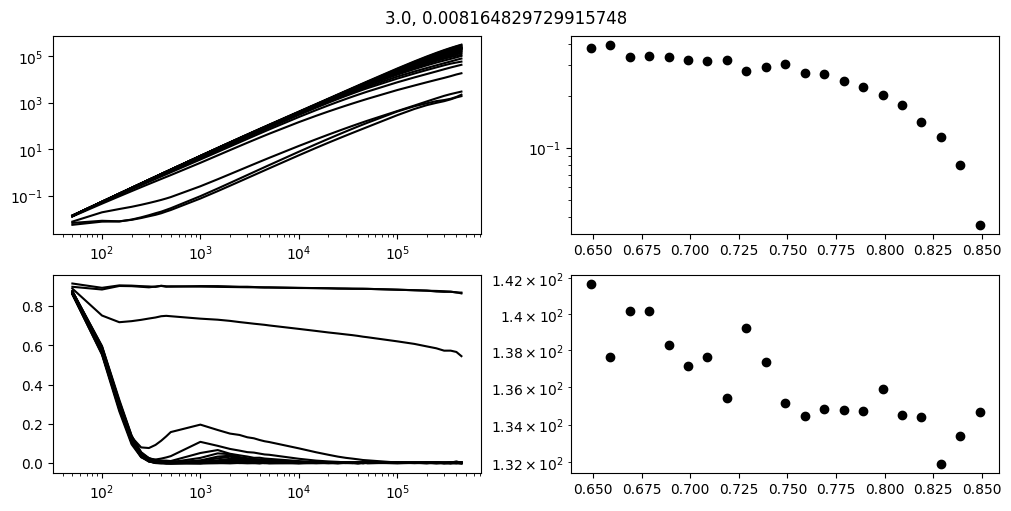

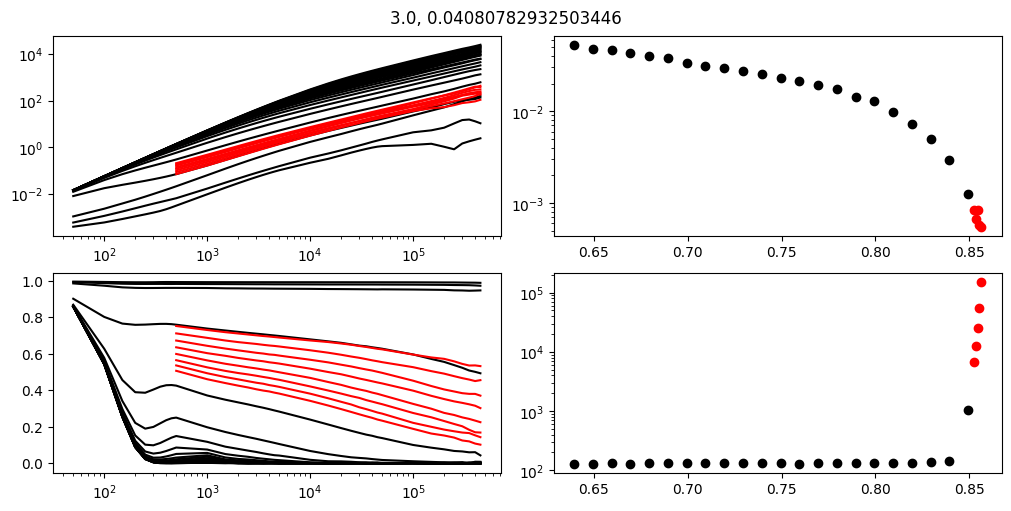

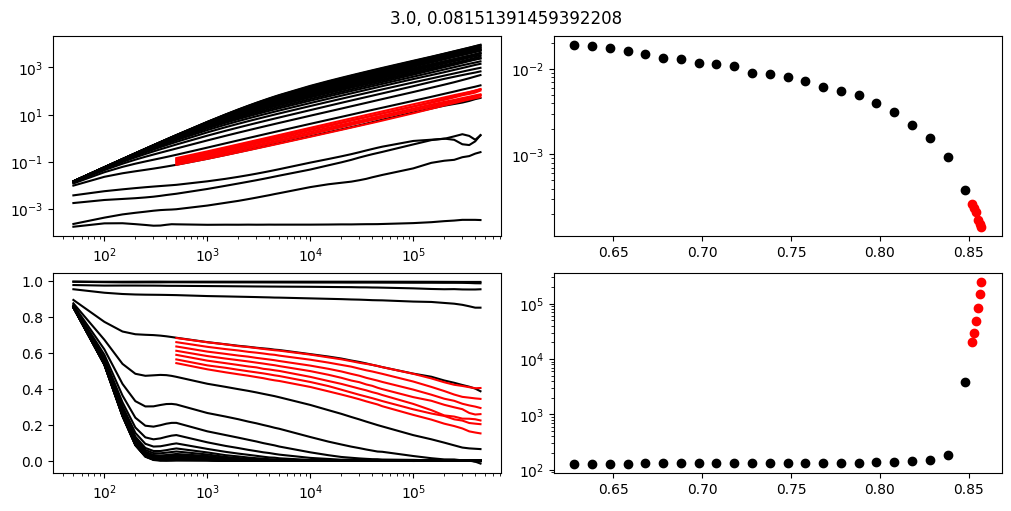

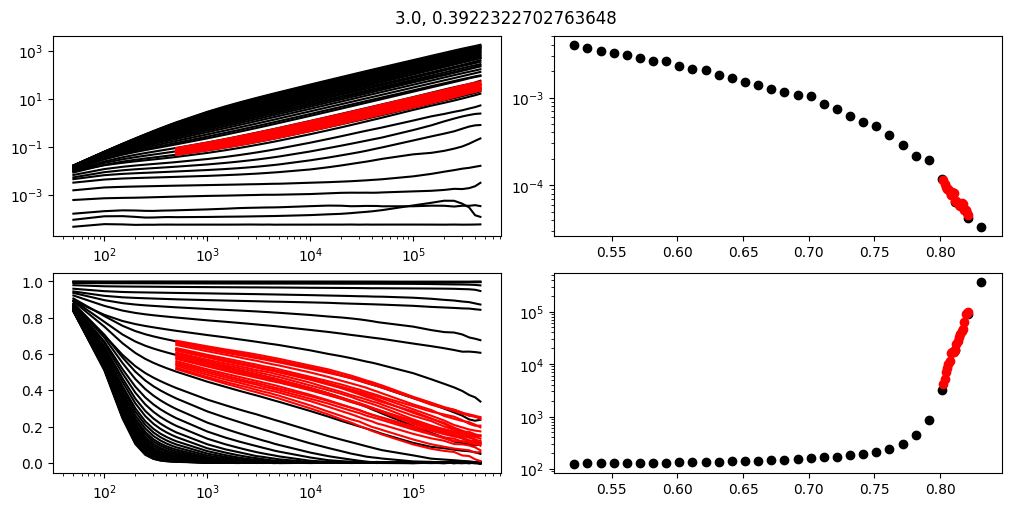

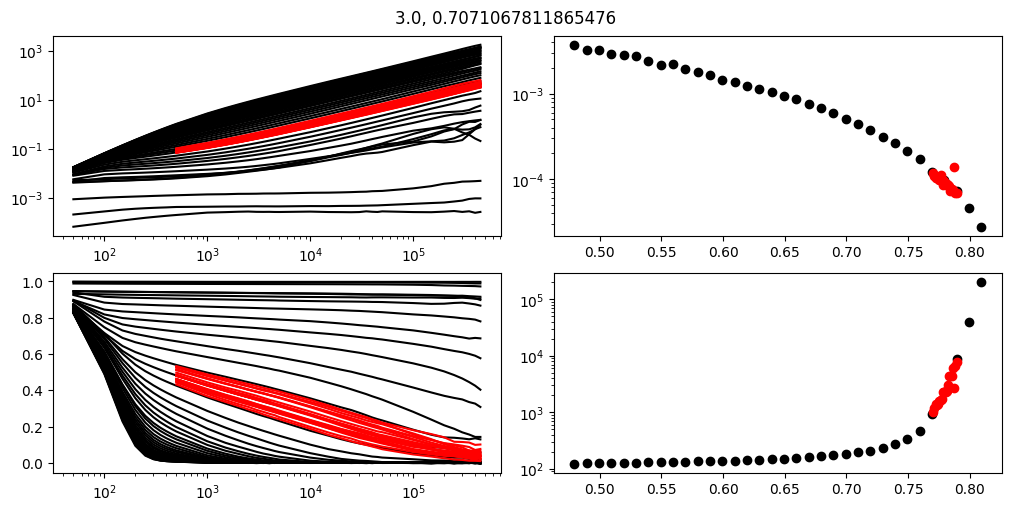

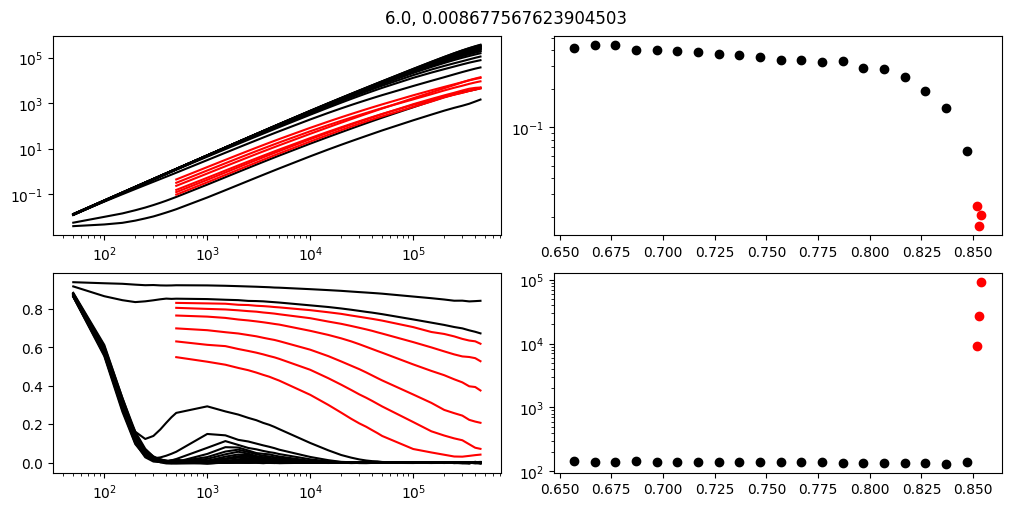

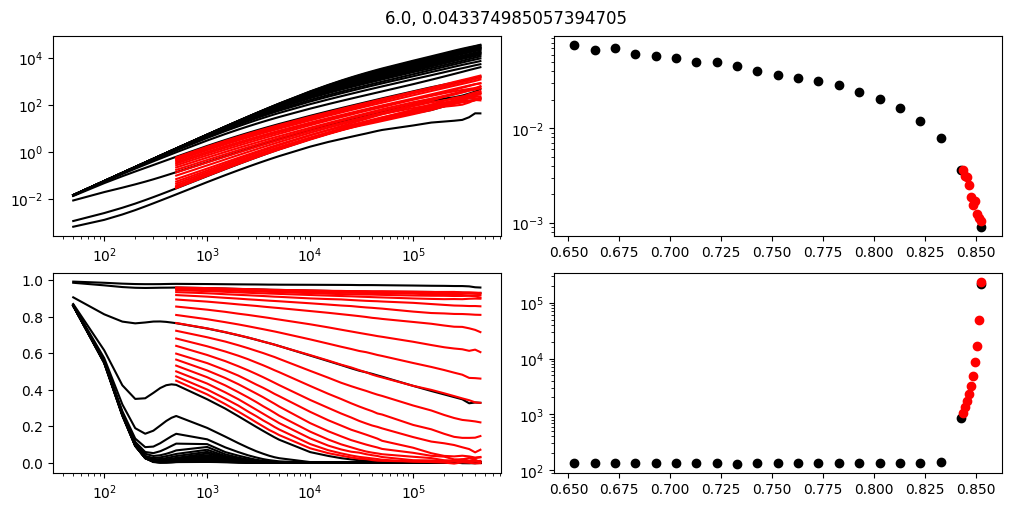

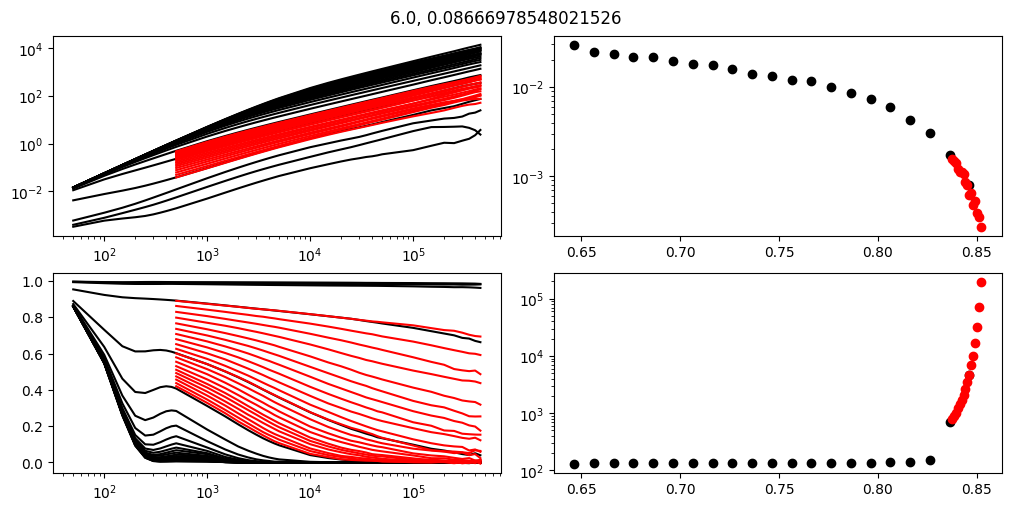

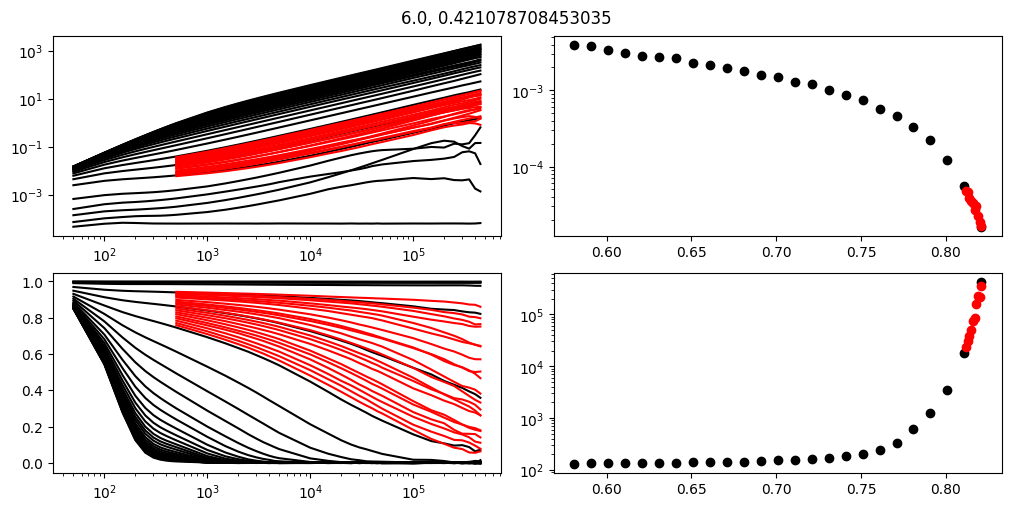

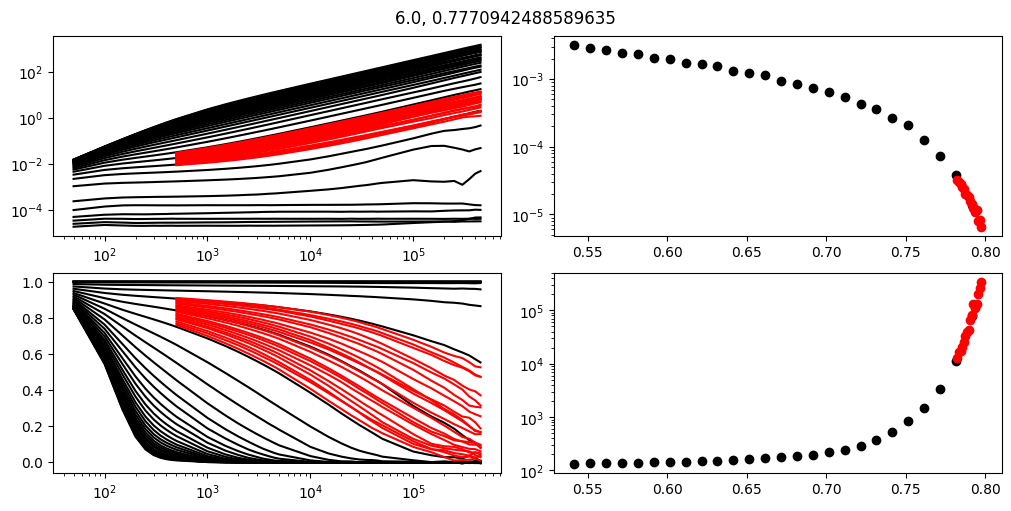

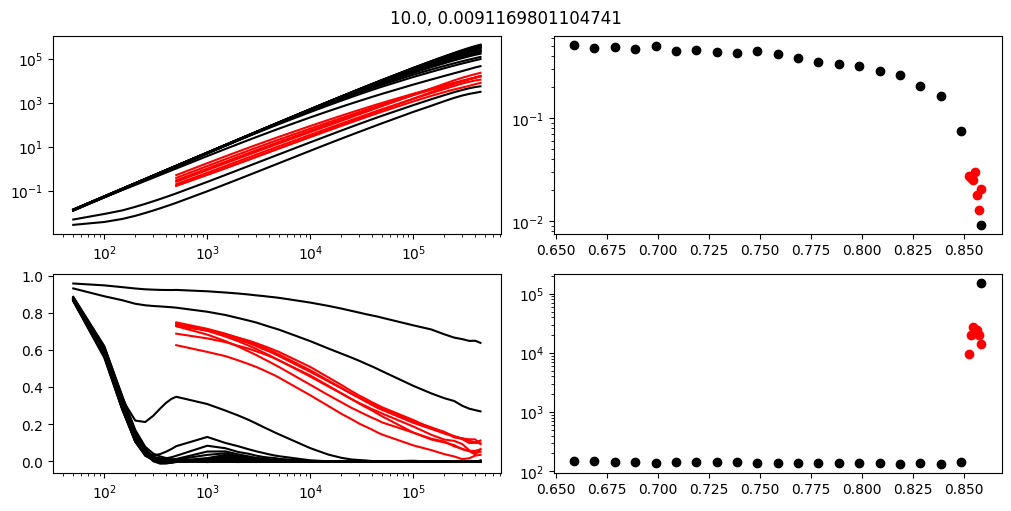

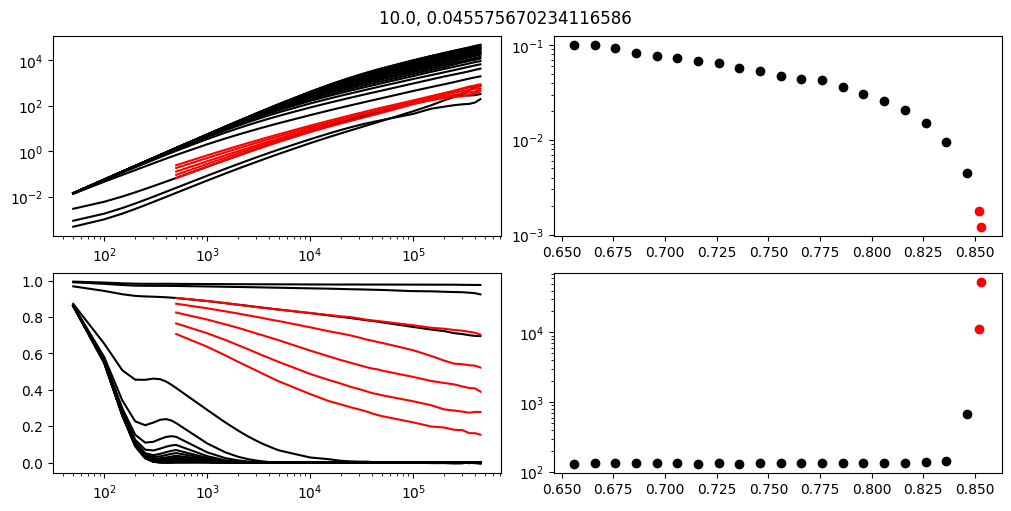

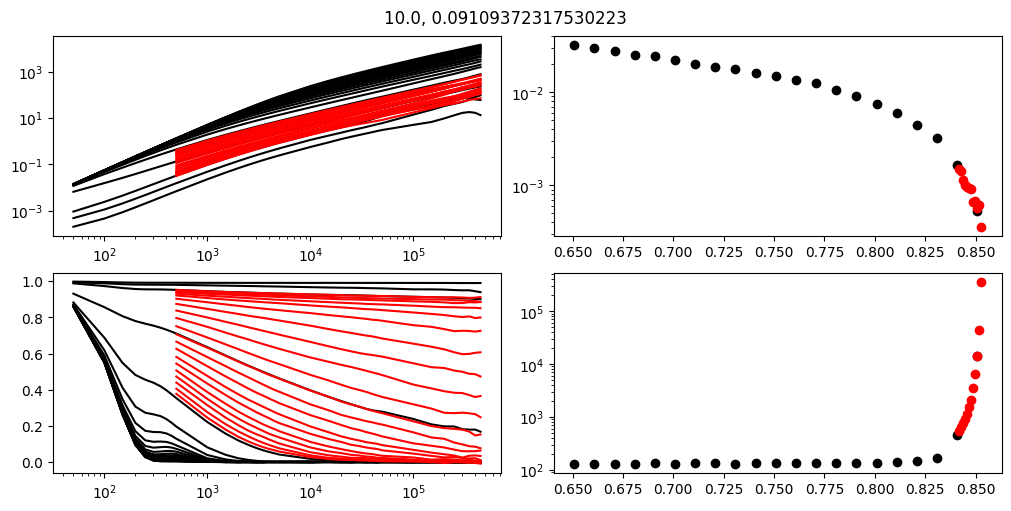

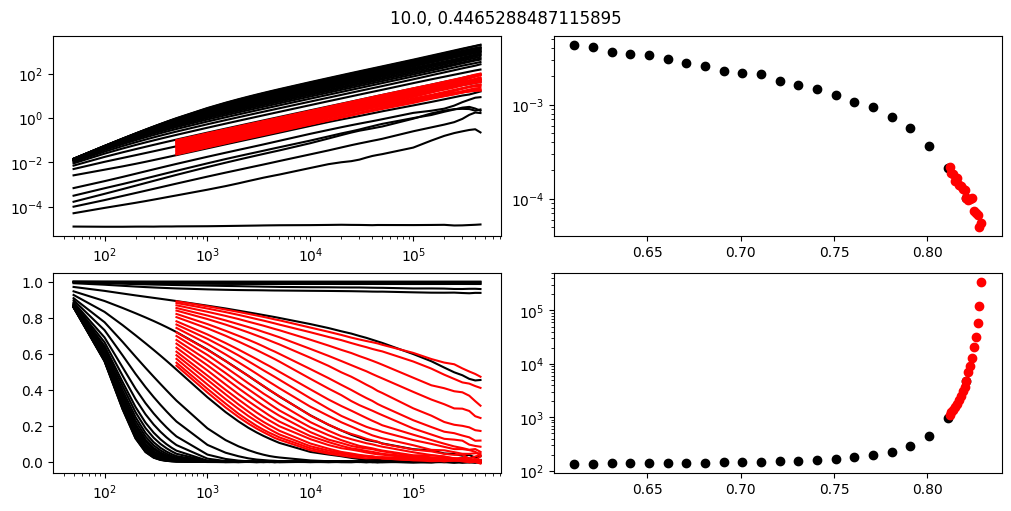

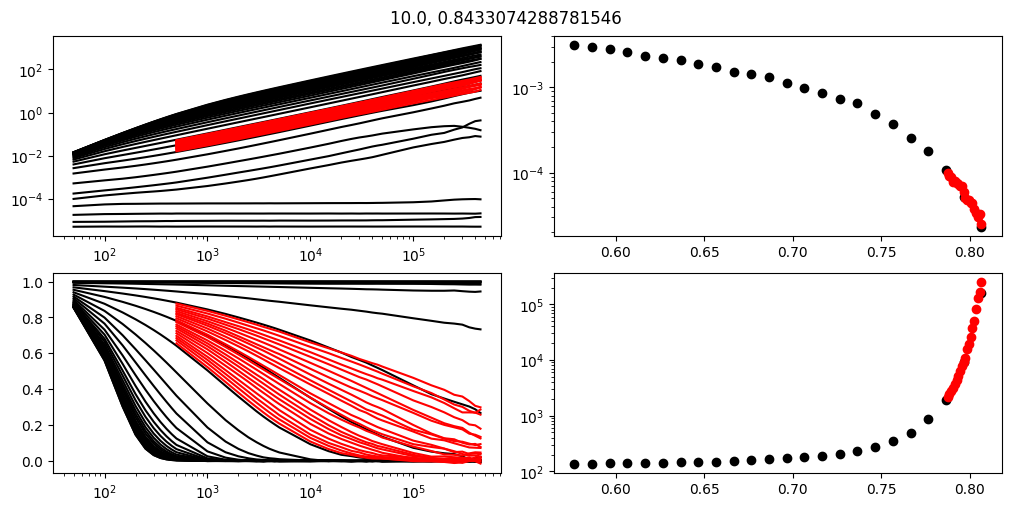

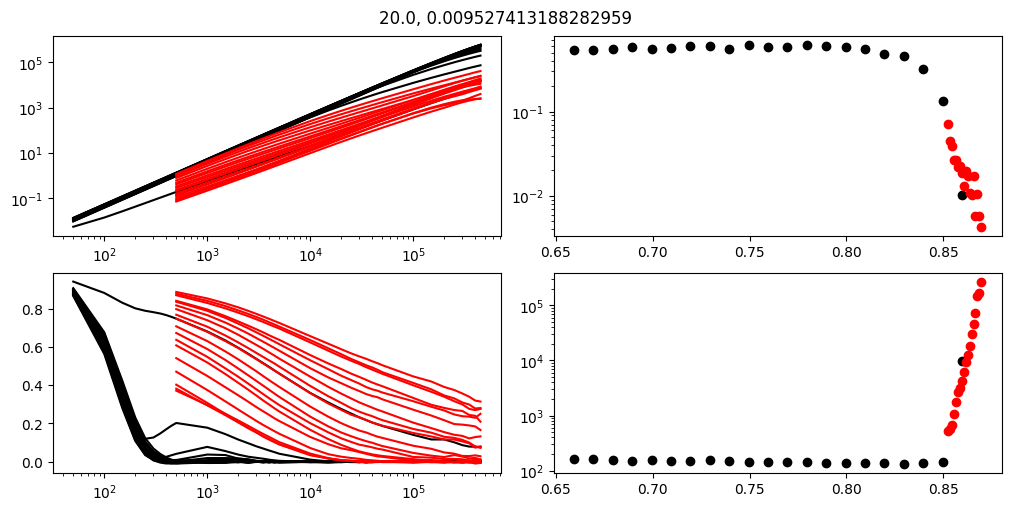

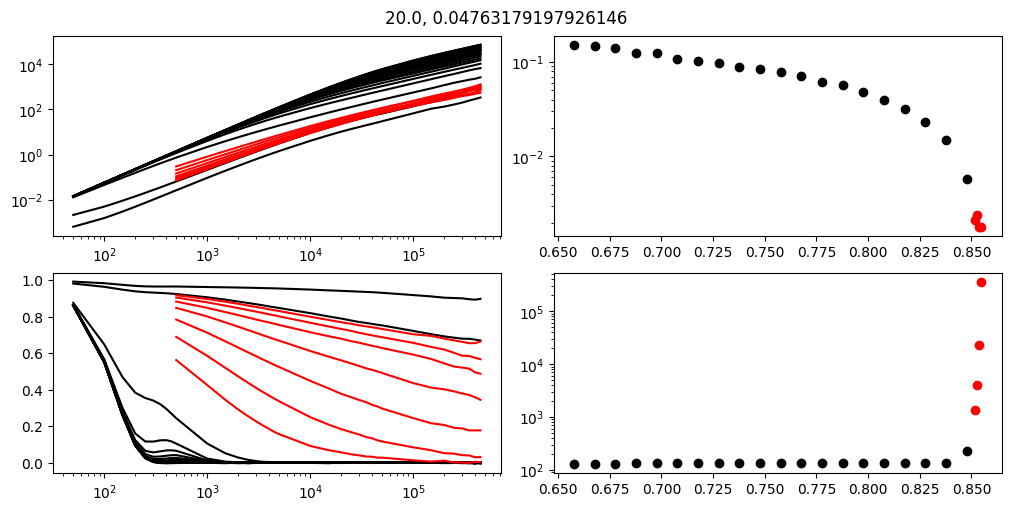

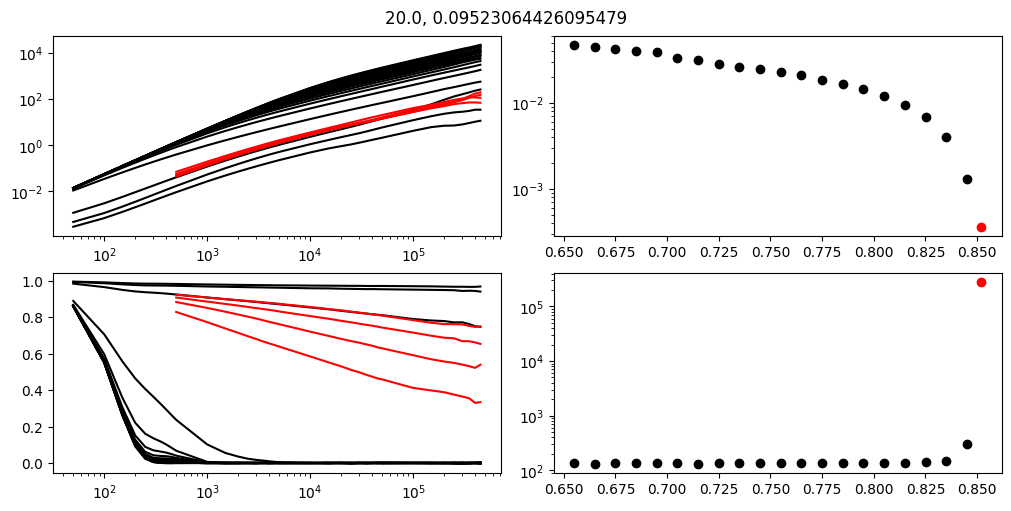

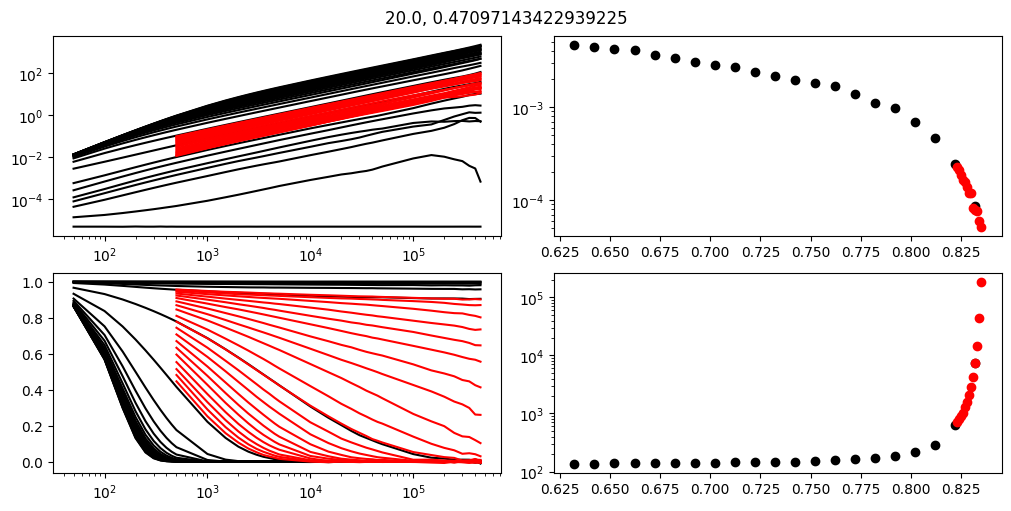

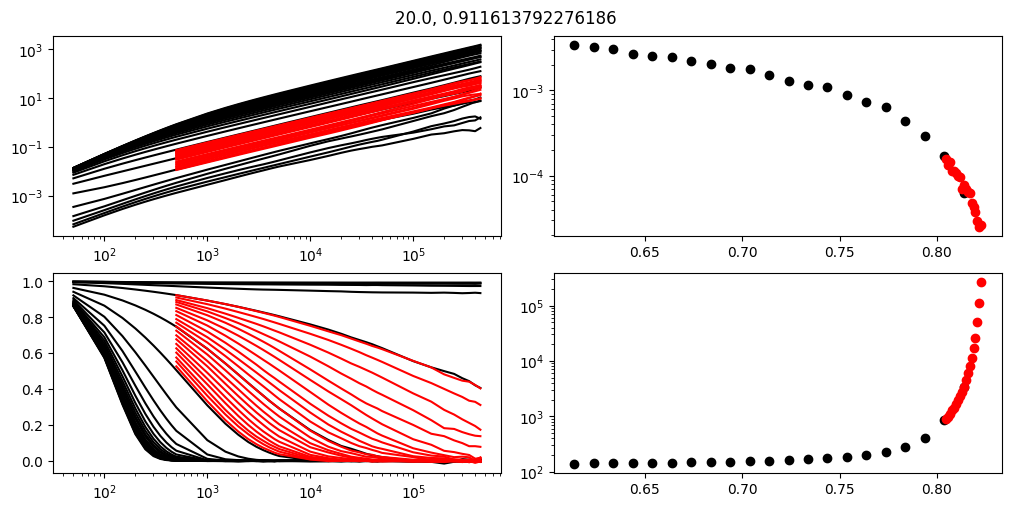

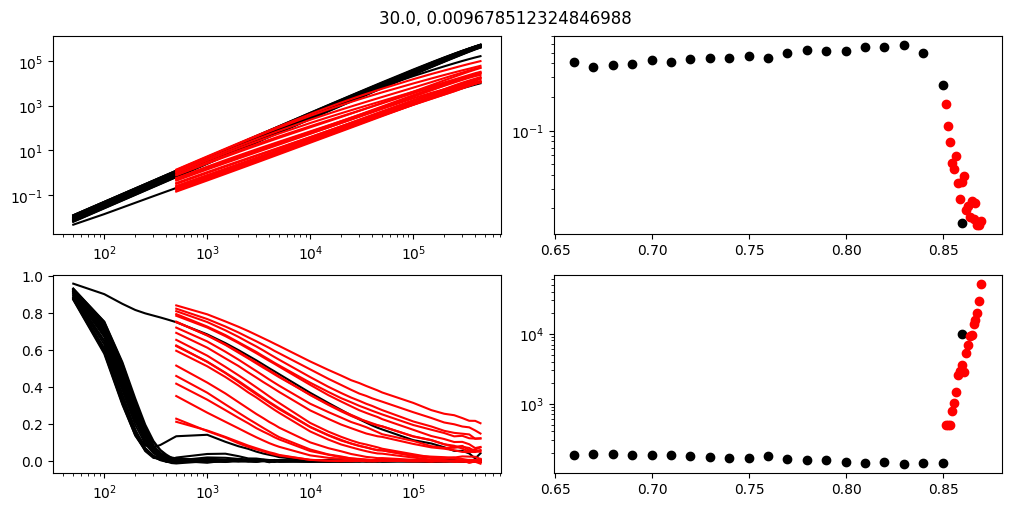

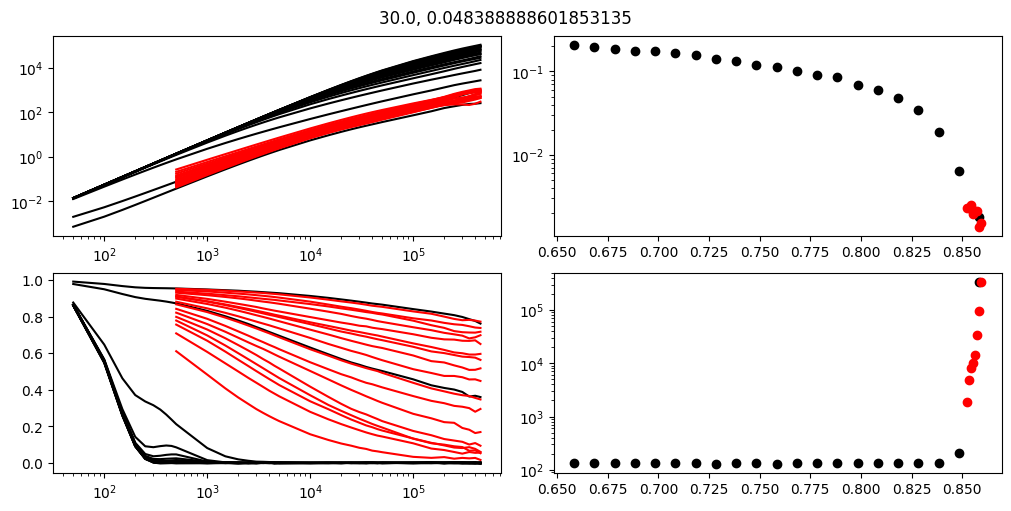

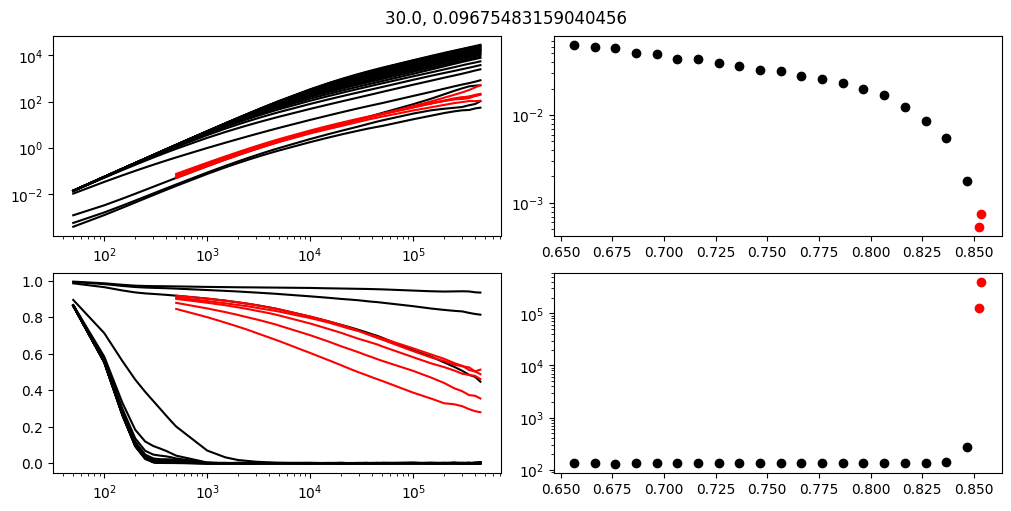

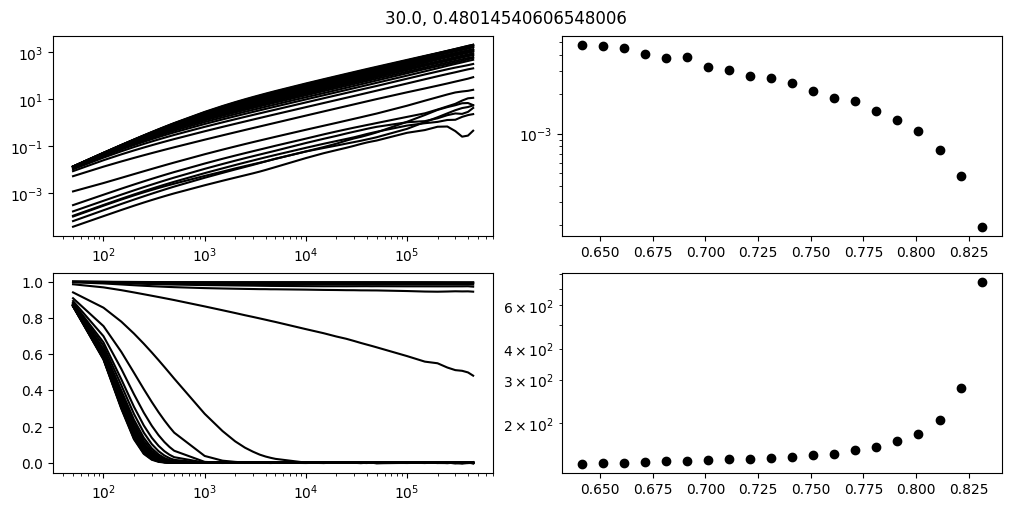

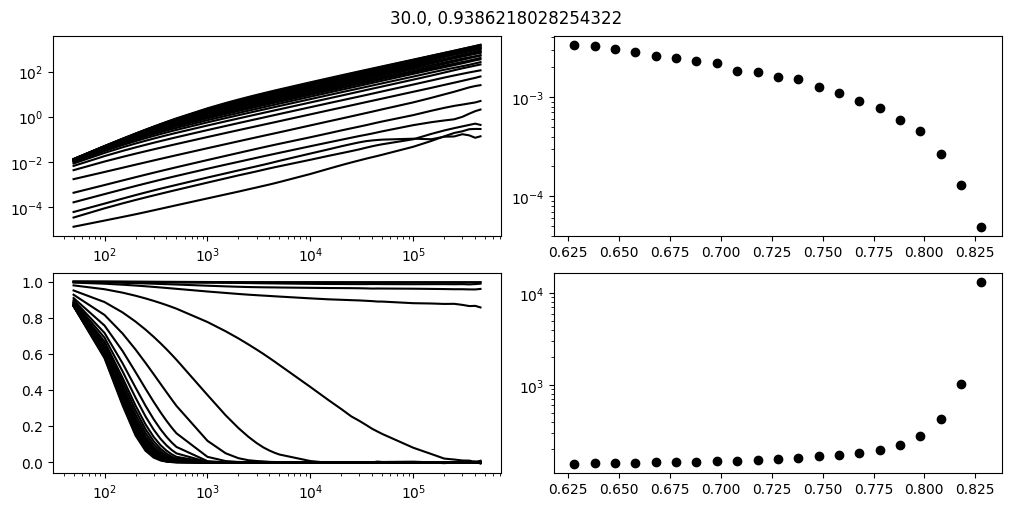

In [69]:
rotational_datasets = {}
for nv_mu in nv_mu_vals:
    dataset = {}
    fig, ax = plt.subplots(2, 2, figsize=(10, 5), constrained_layout=True)
    for data, color in zip([old_data, new_rot_data], ['k', 'r']):
        # this is horrible i apologise
        phi_for_data = np.sort(np.concatenate([[d.packing_fraction[i] for i in range(d.n_systems()) if d.n_vertices_per_particle[d.system_offset[:-1]][i] == _nv and d.mu_eff[d.system_offset[:-1]][i] == _mu] for d in data]))
        for d in data:
            for i, (_nv, _mu) in enumerate(zip(d.n_vertices_per_particle[d.system_offset[:-1]], d.mu_eff[d.system_offset[:-1]])):
                if _nv != nv_mu[0] or _mu != nv_mu[1]:
                    continue
                phi = d.packing_fraction[i]
                
                if color == 'r':
                    if (_nv == 31) or (_nv == 21 and _mu < 0.1) or (_nv == 11 and _mu < 0.05) or (_nv == 7 and _mu < 0.01) or (_nv == 4 and _mu < 0.1):
                        if phi < phi_for_data[1]:
                            continue
                    if (_nv == 4 and _mu < 0.01):
                        continue
                

                t = d.final.t * d.dt[i]
                m = d.final.msd[:, i, 0]
                D, n, R2 = fit_log(t, m, n=1, min_cut_pct=0.1, max_cut_pct=0.9)

                am = d.final.msd[:, i, 1]
                D_R, n_R, R2_R = fit_log(t, am, n=1, min_cut_pct=0.1, max_cut_pct=0.9)

                isf_small = d.final.isf[:, 0, i]
                tau_small = get_relaxation_time(isf_small, t)

                isf_large = d.final.isf[:, 1, i]
                tau_large = get_relaxation_time(isf_large, t)

                aisf_small = d.final.angular_isf[:, 0, i]
                tau_R_small = get_relaxation_time(aisf_small, t)
                
                aisf_large = d.final.angular_isf[:, 1, i]
                tau_R_large = get_relaxation_time(aisf_large, t)

                if np.isnan(tau_small):
                    D = np.nan
                if np.isnan(tau_R_small):
                    D_R = np.nan

                dataset[phi] = {
                    'D': D,
                    'D_R': D_R,
                    'tau_small': tau_small,
                    'tau_R_small': tau_R_small,
                    'tau_large': tau_large,
                    'tau_R_large': tau_R_large,
                }
                ax[0, 0].plot(t, am, color=color)
                ax[0, 1].scatter(phi, D_R, color=color)
                ax[1, 0].plot(t, aisf_small, color=color)
                ax[1, 1].scatter(phi, tau_R_small, color=color)
    for a in ax[:, -1]:
        a.set_yscale('log')
    for a in ax[:, 0]:
        a.set_xscale('log')
    ax[0, 0].set_yscale('log')
    plt.suptitle(f'{nv_mu[0]-1}, {nv_mu[1]}')
    plt.show()
    rotational_datasets[tuple(nv_mu)] = dataset

# Plotting

In [105]:
effective_geom_data = pd.read_csv('/Users/marshallmccraw/Projects/yale/analysis/fall-25/10/effective-diameter/effective_geometry_data.csv')
trans_phi_c_data = pd.read_csv('/Users/marshallmccraw/Projects/yale/analysis/fall-25/10/resumed-dynamics-runs/trans_phi_c_data.csv')
rot_phi_c_data = pd.read_csv('/Users/marshallmccraw/Projects/yale/analysis/fall-25/10/resumed-dynamics-runs/rot_phi_c_data.csv')
phi_j_data = pd.read_csv('/Users/marshallmccraw/Projects/yale/analysis/fall-25/10/analyzing-data-from-cluster/jamming/phi_j_data.csv')

/var/folders/f5/gw8thzr169xd6l47yn540sf80000gn/T/ipykernel_80026/4136298097.py:67: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[0].scatter(x_raw, tau_small, c=color)
/var/folders/f5/gw8thzr169xd6l47yn540sf80000gn/T/ipykernel_80026/4136298097.py:85: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[1].scatter(x_raw, D, c=color)


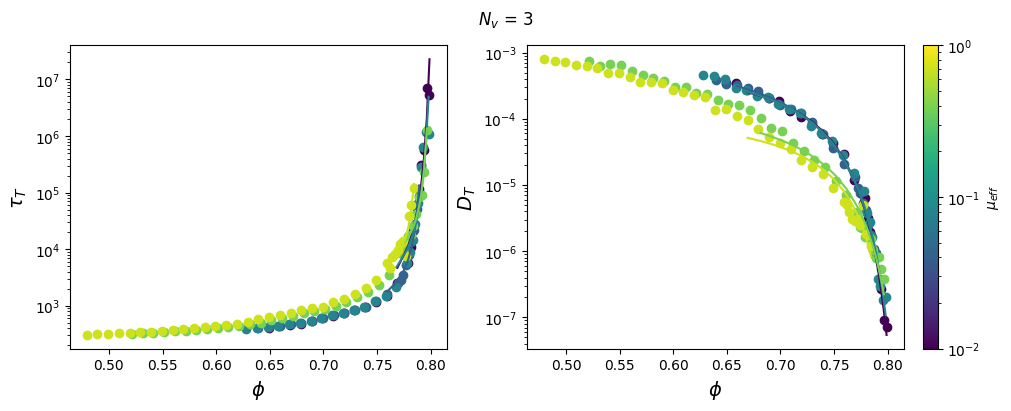

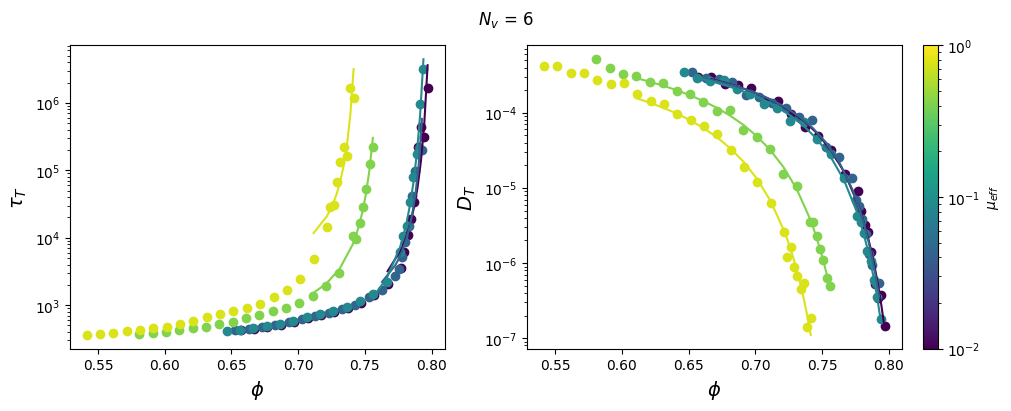

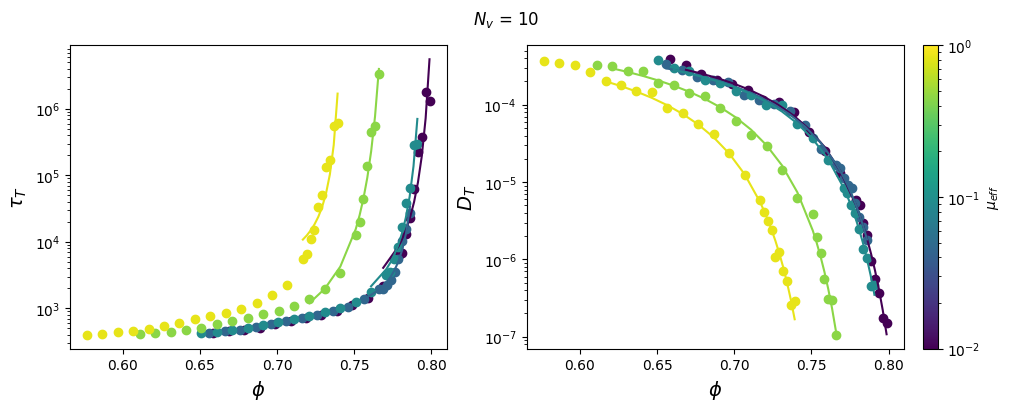

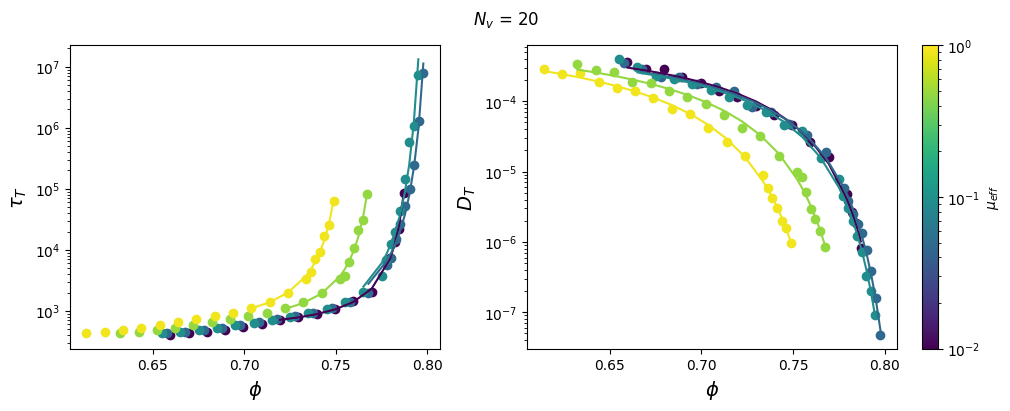

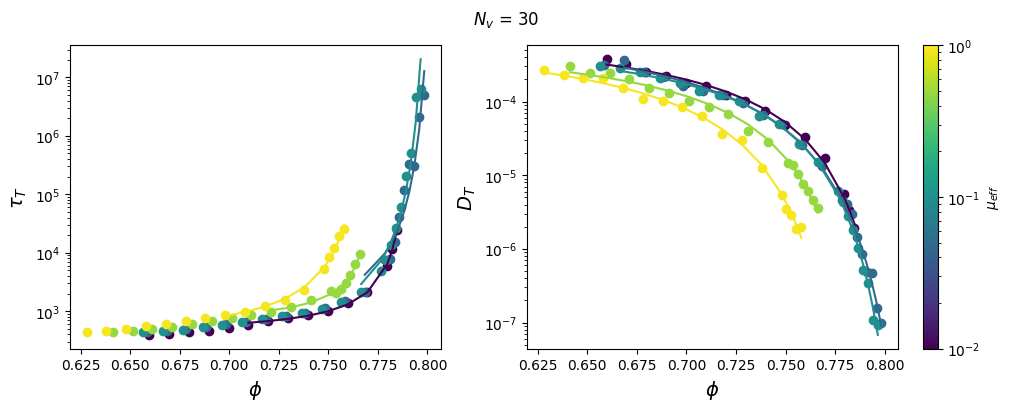

In [132]:
trans_phi_c_dataset = {
    'phi_c_tau_T': [],
    'phi_c_D_T': [],
    'n_tau': [],
    'n_D': [],
    'nv': [],
    'mu': []
}

mu_norm = LogNorm(vmin=1e-2, vmax=1)
cmap = plt.cm.viridis

plot_as_delta = False
how_scale = 'none'

if how_scale not in ['eff', 'outer_eff', 'none']:
    raise ValueError(f'how_scale: {how_scale} not defined!')

for nv in np.unique([_[0] for _ in datasets.keys()]):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
    for nv_mu, dataset in datasets.items():
        if nv_mu[0] != nv:
            continue
        phi = np.array(list(dataset.keys()))
        D = np.array([_['D'] for _ in list(dataset.values())])
        D_R = np.array([_['D_R'] for _ in list(dataset.values())])
        tau_small = np.array([_['tau_small'] for _ in list(dataset.values())])
        tau_large = np.array([_['tau_large'] for _ in list(dataset.values())])
        tau_R_small = np.array([_['tau_R_small'] for _ in list(dataset.values())])
        tau_R_large = np.array([_['tau_R_large'] for _ in list(dataset.values())])

        trans_phi_c_dataset['mu'].append(nv_mu[1])
        trans_phi_c_dataset['nv'].append(nv_mu[0])

        order = np.argsort(phi)
        phi = phi[order]
        D = D[order]
        D_R = D_R[order]
        tau_small = tau_small[order]
        tau_large = tau_large[order]
        tau_R_small = tau_R_small[order]
        tau_R_large = tau_R_large[order]
        color = cmap(mu_norm(nv_mu[1]))

        geom_mask = np.isclose(effective_geom_data.nv, nv) & np.isclose(effective_geom_data.mu_eff, nv_mu[1])
        if how_scale == 'eff':
            scale = (effective_geom_data[geom_mask].phi_eff / effective_geom_data[geom_mask].phi).values[0]
        elif how_scale == 'outer_eff':
            scale = (effective_geom_data[geom_mask].outer_phi_eff / effective_geom_data[geom_mask].phi).values[0]
        else:
            scale = 1
        phi *= scale

        max_points = 10
        x = phi.copy()
        y = tau_small.copy()
        mask = ~(np.isnan(x) | np.isnan(y))
        y = y[mask][-max_points:]
        x = x[mask][-max_points:]
        fit = fit_tau_density_vft(x, y)
        if plot_as_delta:
            x_raw = fit['phi0'] - phi
            x_fit = fit['phi0'] - x
        else:
            x_raw = phi
            x_fit = x
        ax[0].scatter(x_raw, tau_small, c=color)
        ax[0].plot(x_fit, fit['tau0'] * np.exp(fit['A'] / np.abs(fit['phi0'] - x) ** fit['delta']), c=color)
        trans_phi_c_dataset['phi_c_tau_T'].append(fit['phi0'])
        trans_phi_c_dataset['n_tau'].append(fit['delta'])

        max_points = 20
        x = phi.copy()
        y = D.copy()
        mask = ~(np.isnan(x) | np.isnan(y))
        y = y[mask][-max_points:]
        x = x[mask][-max_points:]
        fit = fit_D_density_vft(x, y)
        if plot_as_delta:
            x_raw = fit['phi0'] - phi
            x_fit = fit['phi0'] - x
        else:
            x_raw = phi
            x_fit = x
        ax[1].scatter(x_raw, D, c=color)
        ax[1].plot(x_fit, fit['D0'] * np.exp(-fit['b'] / np.abs(fit['phi0'] - x) ** fit['delta']), c=color)
        trans_phi_c_dataset['phi_c_D_T'].append(fit['phi0'])
        trans_phi_c_dataset['n_D'].append(fit['delta'])

    if how_scale == 'eff':
        phi_label = r'$\phi_{eff}$'
    elif how_scale == 'outer_eff':
        phi_label = r'$\phi_{eff-Disk}$'
    else:
        phi_label = r'$\phi$'

    for a in ax:
        a.set_yscale('log')
        if plot_as_delta:
            a.set_xscale('log')
            a.set_xlabel(fr'$\phi_c - {phi_label}$', fontsize=14)
        else:
            a.set_xlabel(phi_label, fontsize=14)
    ax[0].set_ylabel(r'$\tau_T$', fontsize=14)
    ax[1].set_ylabel(r'$D_T$', fontsize=14)
    plt.suptitle(fr'$N_v$ = {int(nv) - 1}')
    sm = plt.cm.ScalarMappable(norm=mu_norm, cmap=cmap)
    sm.set_array(np.unique([_[1] for _ in datasets.keys()]))
    cbar = plt.colorbar(sm, ax=plt.gca(), label=r'$\mu_{eff}$')
    plt.savefig(f'figures/critical-density-translations/NV-{nv-1}-delta-{plot_as_delta}-scale-{how_scale}.png', dpi=600)
    plt.show()

In [123]:
effective_geom_data[geom_mask]

phi   phi_eff  outer_phi_eff  sigma_eff_small  sigma_eff_large  \
0  0.589765  0.589772            0.6          0.99603         1.384725   

   relative_rms_roughness_small  relative_rms_roughness_large  \
0                      1.000006                      1.000048   

   outer_sigma_small  outer_sigma_large    mu_eff  nv  
0                1.0                1.4  0.008165   4

/var/folders/f5/gw8thzr169xd6l47yn540sf80000gn/T/ipykernel_80026/2674549885.py:52: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[0].scatter(x_raw, tau_R_small, c=color)
/var/folders/f5/gw8thzr169xd6l47yn540sf80000gn/T/ipykernel_80026/2674549885.py:70: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[1].scatter(x_raw, D_R, c=color)


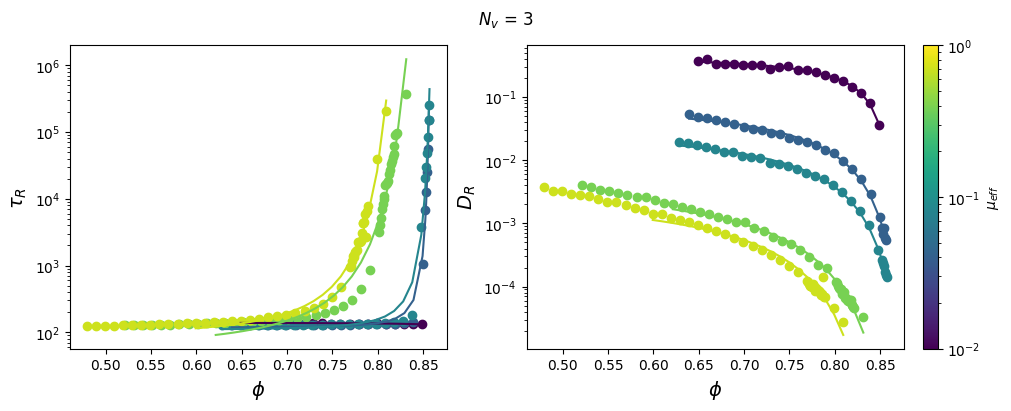

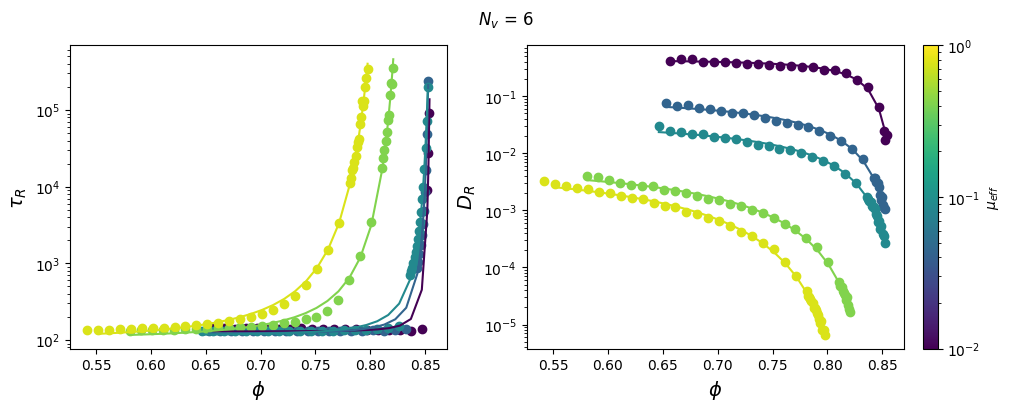

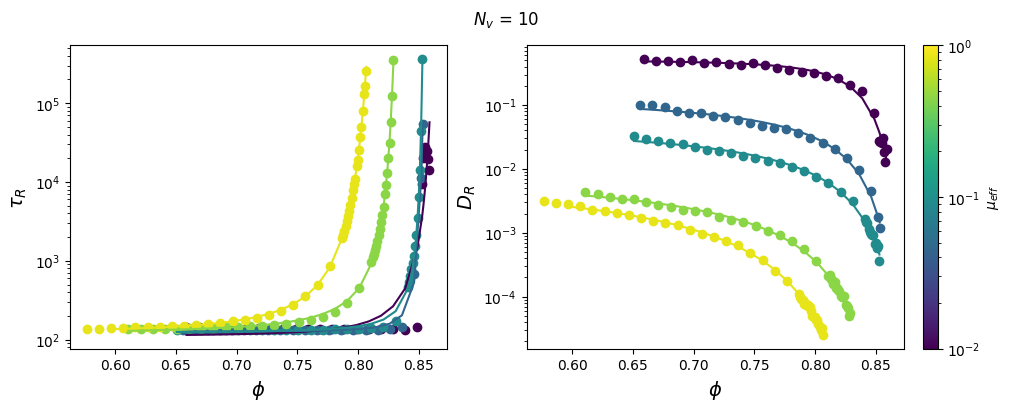

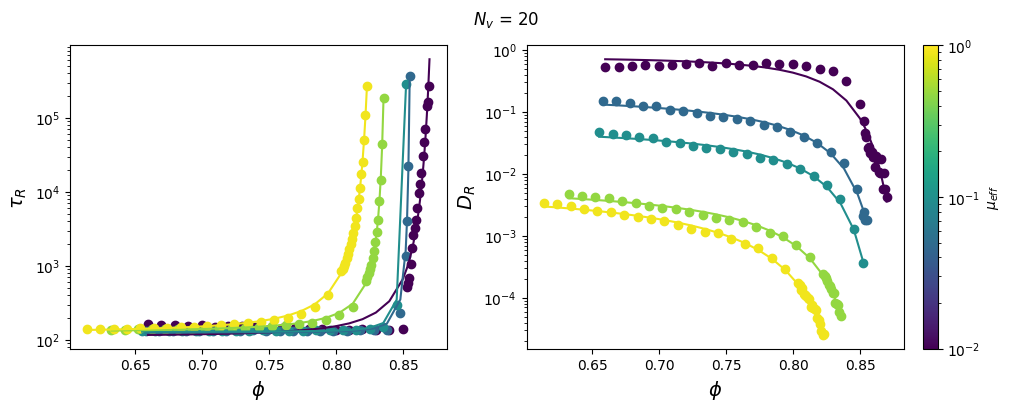

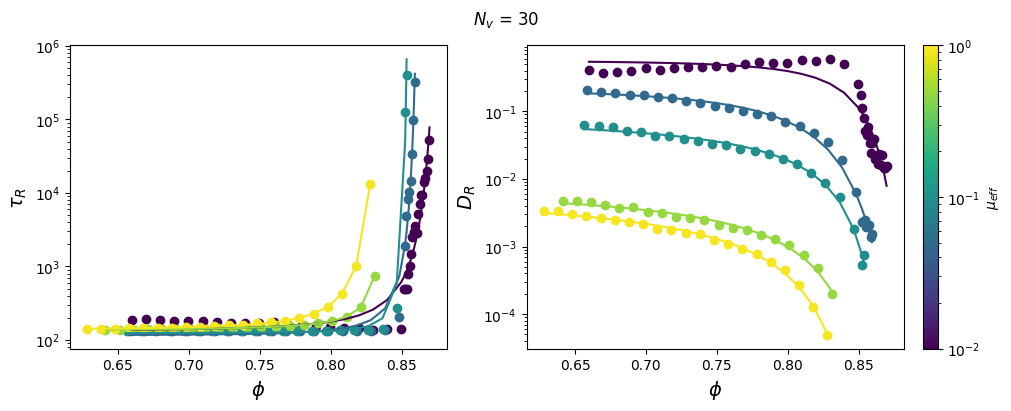

In [104]:
plot_as_delta = False

rot_phi_c_dataset = {
    'phi_c_tau_R': [],
    'phi_c_D_R': [],
    'n_tau': [],
    'n_D': [],
    'nv': [],
    'mu': []
}


for nv in np.unique([_[0] for _ in rotational_datasets.keys()]):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
    for nv_mu, dataset in rotational_datasets.items():
        if nv_mu[0] != nv:
            continue
        phi = np.array(list(dataset.keys()))
        D = np.array([_['D'] for _ in list(dataset.values())])
        D_R = np.array([_['D_R'] for _ in list(dataset.values())])
        tau_small = np.array([_['tau_small'] for _ in list(dataset.values())])
        tau_large = np.array([_['tau_large'] for _ in list(dataset.values())])
        tau_R_small = np.array([_['tau_R_small'] for _ in list(dataset.values())])
        tau_R_large = np.array([_['tau_R_large'] for _ in list(dataset.values())])

        rot_phi_c_dataset['mu'].append(nv_mu[1])
        rot_phi_c_dataset['nv'].append(nv_mu[0])

        order = np.argsort(phi)
        phi = phi[order]
        D = D[order]
        D_R = D_R[order]
        tau_small = tau_small[order]
        tau_large = tau_large[order]
        tau_R_small = tau_R_small[order]
        tau_R_large = tau_R_large[order]
        color = cmap(mu_norm(nv_mu[1]))

        max_points = 40
        x = phi.copy()
        y = tau_R_small.copy()
        mask = ~(np.isnan(x) | np.isnan(y))
        y = y[mask][-max_points:]
        x = x[mask][-max_points:]
        fit = fit_tau_density_vft(x, y)
        if plot_as_delta:
            x_raw = fit['phi0'] - phi
            x_fit = fit['phi0'] - x
        else:
            x_raw = phi
            x_fit = x
        ax[0].scatter(x_raw, tau_R_small, c=color)
        ax[0].plot(x_fit, fit['tau0'] * np.exp(fit['A'] / np.abs(fit['phi0'] - x) ** fit['delta']), c=color)
        rot_phi_c_dataset['phi_c_tau_R'].append(fit['phi0'])
        rot_phi_c_dataset['n_tau'].append(fit['delta'])

        max_points = 40
        x = phi.copy()
        y = D_R.copy()
        mask = ~(np.isnan(x) | np.isnan(y))
        y = y[mask][-max_points:]
        x = x[mask][-max_points:]
        fit = fit_D_density_vft(x, y)
        if plot_as_delta:
            x_raw = fit['phi0'] - phi
            x_fit = fit['phi0'] - x
        else:
            x_raw = phi
            x_fit = x
        ax[1].scatter(x_raw, D_R, c=color)
        ax[1].plot(x_fit, fit['D0'] * np.exp(-fit['b'] / np.abs(fit['phi0'] - x) ** fit['delta']), c=color)
        rot_phi_c_dataset['phi_c_D_R'].append(fit['phi0'])
        rot_phi_c_dataset['n_D'].append(fit['delta'])

    for a in ax:
        a.set_yscale('log')
        if plot_as_delta:
            a.set_xscale('log')
            a.set_xlabel(r'$\phi_c - \phi$', fontsize=14)
        else:
            a.set_xlabel(r'$\phi$', fontsize=14)
    ax[0].set_ylabel(r'$\tau_R$', fontsize=14)
    ax[1].set_ylabel(r'$D_R$', fontsize=14)
    plt.suptitle(fr'$N_v$ = {int(nv) - 1}')
    sm = plt.cm.ScalarMappable(norm=mu_norm, cmap=cmap)
    sm.set_array(np.unique([_[1] for _ in datasets.keys()]))
    cbar = plt.colorbar(sm, ax=plt.gca(), label=r'$\mu_{eff}$')
    plt.savefig(f'figures/critical-density-rotations/NV-{nv-1}-delta-{plot_as_delta}.png', dpi=600)
    plt.show()

In [32]:
trans_df = pd.DataFrame(trans_phi_c_dataset)
trans_df.to_csv('trans_phi_c_data.csv', index=False)
rot_df = pd.DataFrame(rot_phi_c_dataset)
rot_df.to_csv('rot_phi_c_data.csv', index=False)

In [33]:
phi_j_data = pd.read_csv('/Users/marshallmccraw/Projects/yale/analysis/fall-25/10/analyzing-data-from-cluster/jamming/phi_j_data.csv')
phi_j_range_data = pd.read_csv('/Users/marshallmccraw/Projects/yale/analysis/fall-25/10/resumed-dynamics-runs/phi_j_range_data.csv')

In [ ]:
nv_norm = plt.Normalize(vmin=trans_df.nv.min(), vmax=trans_df.nv.max())
fig, ax = plt.subplots(1, 2, sharex=True, constrained_layout=True, figsize=(8, 4))
for nv in np.unique(trans_df.nv):
    mask = trans_df.nv == nv
    ax[0].plot(trans_df.mu[mask], trans_df.phi_c_tau_T[mask], c=cmap(nv_norm(nv)), marker='o')
    # ax[0].plot(trans_df.mu[mask], trans_df.phi_c_D_T[mask], c=cmap(nv_norm(nv)), marker='o')
    ax[1].plot(rot_df.mu[mask], rot_df.phi_c_tau_R[mask], c=cmap(nv_norm(nv)), marker='o')
    # ax[1].plot(rot_df.mu[mask], rot_df.phi_c_D_R[mask], c=cmap(nv_norm(nv)), marker='o')
    
    phi_j_mask = phi_j_data.nv == nv - 1
    # ax[0].plot(phi_j_data.mu[phi_j_mask], phi_j_data.phi_j[phi_j_mask], c=cmap(nv_norm(nv)))

    phi_j_range_mask = phi_j_data.nv == nv
    ax[1].plot(phi_j_range_data.mu[phi_j_mask], phi_j_range_data.phi_j_max[phi_j_mask], c=cmap(nv_norm(nv)), marker='s', alpha=0.2)
    # ax[0].plot(phi_j_range_data.mu[phi_j_mask], phi_j_range_data.phi_j_min[phi_j_mask], c=cmap(nv_norm(nv)), marker='+')

ax[1].plot([], [], marker='s', color='k', alpha=0.5, label=r'$\phi_{J,max}$')
ax[1].legend()

for a in ax:
    a.set_xscale('log')
    a.set_xlabel(r'$\mu_{eff}$', fontsize=14)
ax[0].set_ylabel(r'$\phi_{c,T}$', fontsize=14)
ax[1].set_ylabel(r'$\phi_{c,R}$', fontsize=14)
sm = plt.cm.ScalarMappable(norm=nv_norm, cmap=cmap)
sm.set_array(trans_df.nv.unique())
cbar = plt.colorbar(sm, ax=plt.gca(), label=r'$N_v$')
plt.savefig('figures/critical-densities.png', dpi=600)